# Displacement Tracking and Analysis for Ablation Assay

This notebook performs automated displacement tracking and analysis for tissue ablation experiments:

- **Frame correlation analysis** to detect ablation events
- **Optical flow estimation** to track tissue displacement
- **Strain field calculation** and visualization
- **Ablation site estimation** based on displacement patterns
- **Interactive visualization** and data export

In [1]:
import tkinter as tk
from tkinter import filedialog
import numpy as np
import tifffile
import cv2
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import os
import csv
import gc
import math


def select_tif_file():
    root = tk.Tk()
    root.withdraw()
    root.attributes('-topmost', True)
    plt.close('all')  # Close any existing plots
    
    file_path = filedialog.askopenfilename(
        title="Select a TIFF Stack",
        filetypes=[("TIFF files", "*.tif *.tiff")]
    )
    
    root.destroy()  # Explicitly destroy the root window
    return file_path

def load_and_preprocess_stack(file_path):
    # Load TIFF stack
    image_stack = tifffile.imread(file_path)
    
    # Convert to 8-bit grayscale if not already
    if image_stack.dtype != np.uint8:
        image_stack = (image_stack / np.max(image_stack) * 255).astype(np.uint8)
    
    # Ensure all images are 2D (grayscale)
    # Check if this is a stack of images or a single image
    if len(image_stack.shape) == 4:  # Stack of color images [frames, height, width, channels]
        processed_stack = []
        for img in image_stack:
            if img.shape[2] == 3:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            elif img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
            else:
                img = img[:, :, 0]
            processed_stack.append(img)
        image_stack = np.array(processed_stack)
    elif len(image_stack.shape) == 3:
        # Could be either a stack of grayscale images or a single color image
        # Check if the last dimension is likely channels (small number like 3 or 4)
        if image_stack.shape[-1] in [3, 4] and image_stack.shape[0] > 4:
            # Likely a single color image [height, width, channels]
            if image_stack.shape[2] == 3:
                image_stack = cv2.cvtColor(image_stack, cv2.COLOR_RGB2GRAY)
            elif image_stack.shape[2] == 4:
                image_stack = cv2.cvtColor(image_stack, cv2.COLOR_RGBA2GRAY)
            else:
                image_stack = image_stack[:, :, 0]
        # Otherwise assume it's a stack of grayscale images [frames, height, width]
        # No processing needed
    
    return image_stack

def analyze_frame_correlations(image_stack):
    # Calculate mean-centered correlations between successive frames
    correlations = []
    
    for i in range(len(image_stack) - 1):
        # Mean-center both images
        img1 = image_stack[i]
        img2 = image_stack[i+1]
        
        img1_centered = img1 - np.mean(img1)
        img2_centered = img2 - np.mean(img2)
        
        # Compute normalized cross-correlation
        correlation = np.corrcoef(img1_centered.ravel(), img2_centered.ravel())[0, 1]
        correlations.append(correlation)
    
    # Plot correlations
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(correlations)), correlations, marker='o')
    plt.title('Frame-to-Frame Cross-Correlation')
    plt.xlabel('Frame Pair Index')
    plt.ylabel('Mean-Centered Correlation')
    plt.tight_layout()
    save_current_figure('01_frame_to_frame_correlation')
    plt.show()
    
    # Find the frame pair with lowest correlation
    min_corr_index = np.argmin(correlations)
    first_frame_after_ablation = min_corr_index + 1
    
    # Print message about ablation
    print(f"Based on frame-to-frame correlation analysis:")
    print(f"Frame {first_frame_after_ablation} is designated as the first frame after ablation.")
    print(f"Lowest correlation of {correlations[min_corr_index]:.4f} found between frames {min_corr_index} and {min_corr_index+1}")
    
    return first_frame_after_ablation

def calculate_overall_displacement(image_stack, pre_ablation_frame, last_frame):
    """
    Calculate the overall displacement between two specified frames using Farneback method
    
    Parameters:
    - image_stack: Full image stack
    - pre_ablation_frame: Index of the frame just before ablation
    - last_frame: Index of the last frame in the stack
    
    Returns:
    - overall_displacement: Optical flow field
    - registration_metric: Similarity metric between frames
    """
    pre_ablation_img = image_stack[pre_ablation_frame]
    last_img = image_stack[last_frame]
    
    # Estimate displacement field between pre-ablation and last frame
    # reversed order of last_img and pre_ablation_img because warping needs displacements with opposite sign
    overall_displacement = cv2.calcOpticalFlowFarneback(
        last_img,
        pre_ablation_img,  
        None, 
        0.5,   # pyramid scale
        3,     # levels
        15,    # window size
        3,     # iterations
        5,     # polynomial neighborhood
        1.2,   # polynomial sigma
        0      # flags
    )
    
    # Calculate registration metric
    registration_metric = calculate_registration_metric(last_img, overall_displacement, pre_ablation_img)
    
    return overall_displacement, registration_metric

def visualize_overall_displacement(pre_ablation_img, last_img, overall_displacement, registration_metric):
    """
    Create a visualization of the overall displacement between two frames
    
    Parameters:
    - pre_ablation_img: Image before ablation
    - last_img: Last image in the stack
    - overall_displacement: Optical flow field
    - registration_metric: Similarity metric
    """
    # Create a 2x2 subplot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Overall Displacement (Pre-Ablation to Last Frame)', fontsize=16)
    
    # Original Image Overlay
    original_overlay = np.zeros((*pre_ablation_img.shape, 3), dtype=np.uint8)
    original_overlay[:,:,0] = pre_ablation_img  # Red channel
    original_overlay[:,:,1] = last_img  # Green channel
    original_overlay[:,:,2] = pre_ablation_img  # Blue channel (making magenta)
    
    axes[0, 0].imshow(original_overlay)
    axes[0, 0].set_title('Original Image Overlay')
    axes[0, 0].axis('off')
    
    # Displacement Magnitude
    magnitude = np.sqrt(overall_displacement[:,:,0]**2 + overall_displacement[:,:,1]**2)
    im = axes[0, 1].imshow(magnitude, cmap='viridis')
    axes[0, 1].set_title('Displacement Magnitude')
    fig.colorbar(im, ax=axes[0, 1])
    
    # Warped Image Overlay
    rows, cols = pre_ablation_img.shape
    map_x = np.zeros((rows, cols), dtype=np.float32)
    map_y = np.zeros((rows, cols), dtype=np.float32)
    
    for r in range(rows):
        for c in range(cols):
            map_x[r, c] = c + overall_displacement[r, c, 0]
            map_y[r, c] = r + overall_displacement[r, c, 1]
    
    warped_img = cv2.remap(pre_ablation_img, map_x, map_y, cv2.INTER_LINEAR)
    
    warped_overlay = np.zeros((*pre_ablation_img.shape, 3), dtype=np.uint8)
    warped_overlay[:,:,0] = warped_img  # Red channel
    warped_overlay[:,:,1] = last_img  # Green channel
    warped_overlay[:,:,2] = warped_img  # Blue channel (making magenta)
    
    axes[1, 0].imshow(warped_overlay)
    axes[1, 0].set_title('Warped Image Overlay')
    axes[1, 0].axis('off')
    
    # Displacement Vectors
    step = 20
    y, x = np.mgrid[0:overall_displacement.shape[0]:step, 
                    0:overall_displacement.shape[1]:step]
    u = overall_displacement[y, x, 0]
    v = overall_displacement[y, x, 1]
    # minus signs needed below because calculation of displacements was from later to earlier
    axes[1, 1].quiver(x, y, -u, -v, scale=50, color='r')
    axes[1, 1].set_title('Displacement Vectors')
    
    # Add registration metric text
    plt.suptitle(f'Registration Metric: {registration_metric:.4f}', fontsize=12)
    
    plt.tight_layout()
    save_current_figure('09_overall_displacement_visualization')
    plt.show()

def calculate_strain_tensor(displacement_field, window_size=50):
    """
    Calculate the strain tensor for each pixel in the displacement field
    
    Parameters:
    - displacement_field: 2D array of displacement vectors
    - window_size: Size of the neighborhood for strain calculation
    
    Returns:
    - area_strain: 2D array of area strain values
    """
    # Ensure displacement field is float
    disp_x = displacement_field[:,:,0].astype(np.float32)
    disp_y = displacement_field[:,:,1].astype(np.float32)
    
    # Initialize area strain array
    rows, cols = displacement_field.shape[:2]
    area_strain = np.zeros_like(disp_x)
    
    # Half window size
    half_window = window_size // 2
    
    for r in range(half_window, rows - half_window):
        for c in range(half_window, cols - half_window):
            # Extract local displacement window
            local_disp_x = disp_x[r-half_window:r+half_window+1, 
                                  c-half_window:c+half_window+1]
            local_disp_y = disp_y[r-half_window:r+half_window+1, 
                                  c-half_window:c+half_window+1]
            
            # Calculate spatial gradients
            dx_x = np.gradient(local_disp_x)[1]
            dy_y = np.gradient(local_disp_y)[0]
            
            # Calculate area strain (divergence)
            area_strain[r, c] = np.mean(dx_x + dy_y)
    
    return area_strain

def visualize_strain_field(overall_displacement, ablation_site):
    """
    Visualize the strain field from the overall displacement
    
    Parameters:
    - overall_displacement: Optical flow field
    - ablation_site: (x, y) coordinates of estimated ablation location
    """
    # Negate the displacement field
    negated_displacement = -overall_displacement
    
    # Calculate area strain
    area_strain = calculate_strain_tensor(negated_displacement)
    
    # Create figure
    plt.figure(figsize=(15, 5))
    
    # Original Strain Field
    plt.subplot(131)
    im1 = plt.imshow(area_strain, cmap='coolwarm')
    plt.colorbar(im1)
    plt.title('Area Strain Field')
    
    # Mark ablation site
    plt.plot(ablation_site[1], ablation_site[0], 'ro', markersize=10, 
             label='Estimated Ablation Site')
    plt.legend()
    
    # Strain Field Histogram
    plt.subplot(132)
    plt.hist(area_strain.ravel(), bins=50, edgecolor='black')
    plt.title('Strain Field Distribution')
    plt.xlabel('Area Strain')
    plt.ylabel('Frequency')
    
    # Displacement Magnitude around Ablation Site
    plt.subplot(133)
    magnitude = np.sqrt(negated_displacement[:,:,0]**2 + 
                        negated_displacement[:,:,1]**2)
    im3 = plt.imshow(magnitude, cmap='viridis')
    plt.colorbar(im3)
    plt.title('Displacement Magnitude')
    plt.plot(ablation_site[1], ablation_site[0], 'ro', markersize=10)
    
    save_current_figure('10_strain_field_visualization')
    plt.show()

def analyze_displacement_extremes(overall_displacement):
    """
    Analyze displacement field extremes
    
    Parameters:
    - overall_displacement: 2D displacement field
    
    Returns:
    - Dictionary with analysis results including ablation site estimation
    """
    # 1. Find position of largest displacement magnitude
    magnitude = np.sqrt(overall_displacement[:,:,0]**2 + overall_displacement[:,:,1]**2)
    max_disp_pos = np.unravel_index(np.argmax(magnitude), magnitude.shape)
    
    # 2. Retrieve displacement vector at maximum location
    max_disp_vector = overall_displacement[max_disp_pos]
    
    # 3. Find position with most opposite displacement
    # Calculate dot product of each displacement with max displacement vector
    dot_products = np.zeros_like(magnitude)
    for y in range(overall_displacement.shape[0]):
        for x in range(overall_displacement.shape[1]):
            local_disp = overall_displacement[y, x]
            dot_products[y, x] = np.dot(local_disp, max_disp_vector)
    
    # Find position with most negative dot product
    opposite_pos = np.unravel_index(np.argmin(dot_products), dot_products.shape)
    
    # 4. Get displacement vector at opposite position
    opposite_disp_vector = overall_displacement[opposite_pos]
    
    # 5. Calculate distance between points
    distance = np.sqrt(
        (max_disp_pos[0] - opposite_pos[0])**2 + 
        (max_disp_pos[1] - opposite_pos[1])**2
    )
    
    # 6. Estimate ablation site as midpoint between max and opposite displacement positions
    ablation_site = (
        int((max_disp_pos[0] + opposite_pos[0]) / 2),
        int((max_disp_pos[1] + opposite_pos[1]) / 2)
    )
    
    return {
        'max_disp_pos': max_disp_pos,
        'max_disp_vector': max_disp_vector,
        'opposite_pos': opposite_pos,
        'opposite_disp_vector': opposite_disp_vector,
        'distance': distance,
        'ablation_site': ablation_site
    }
    
def visualize_displacement_extremes(overall_displacement):
    """
    Visualize the displacement extremes analysis
    
    Parameters:
    - overall_displacement: 2D displacement field
    
    Returns:
    - Analysis results
    """
    # Perform analysis
    analysis = analyze_displacement_extremes(overall_displacement)
    
    # Visualization
    plt.figure(figsize=(10, 5))
    
    # Displacement magnitude with colored magnitude map
    plt.subplot(121)
    magnitude = np.sqrt(overall_displacement[:,:,0]**2 + overall_displacement[:,:,1]**2)
    plt.imshow(magnitude, cmap='viridis')
    plt.title('Displacement Magnitude')
    plt.colorbar()
    plt.plot(analysis['ablation_site'][1], analysis['ablation_site'][0], marker='*', 
             color='white', markersize=10, label='Estimated Ablation Site', markeredgecolor='white', linestyle='None')
    
    # Overlay displacement vectors for max and opposite points
    max_y, max_x = analysis['max_disp_pos']
    opposite_y, opposite_x = analysis['opposite_pos']
    
    # Ensure consistent vector orientation and scaling
    max_disp_vector = -analysis['max_disp_vector']
    opposite_disp_vector = -analysis['opposite_disp_vector']
    
    # Calculate scaling to make vectors visible
    height, width = overall_displacement.shape[:2]
    vector_scale = min(height, width) / 6  # Increased divisor to make vectors larger
    
    plt.quiver(max_x, max_y, 
               max_disp_vector[0], 
               max_disp_vector[1], 
               color='red', 
               scale=vector_scale,  # Inverting scale to make vectors larger
               angles='xy',
               width=0.01,  # Increase arrow width
               headwidth=5,  # Increase arrow head size
               headlength=7,
               label='Max Displacement')
    
    plt.quiver(opposite_x, opposite_y, 
               opposite_disp_vector[0], 
               opposite_disp_vector[1], 
               color='blue', 
               scale=vector_scale,  # Inverting scale to make vectors larger
               angles='xy',
               width=0.01,  # Increase arrow width
               headwidth=5,  # Increase arrow head size
               headlength=7,
               label='Opposite Displacement')
    
    plt.title('Key Displacement Vectors')
    plt.legend()
    
    # Print analysis details
    plt.subplot(122)
    plt.text(0.5, 0.5, 
             "All Distances and Displacements in pixels\n\n"
             f"Max Displacement Vector: {max_disp_vector}\n"
             f"Max Opposite Displacement Vector: {opposite_disp_vector}\n"
             f"Max Displacement Position: ({int(analysis['max_disp_pos'][0])}, {int(analysis['max_disp_pos'][1])})\n"
             f"Max Opposite Displacement Pos: ({int(analysis['opposite_pos'][0])}, {int(analysis['opposite_pos'][1])})\n"
             f"Distance between these points: {analysis['distance']:.2f}\n"
             f"\nEstimated Ablation Site: {analysis['ablation_site']}\n",
             horizontalalignment='center',
             verticalalignment='center',
             transform=plt.gca().transAxes)
    plt.axis('off')
    plt.title('Analysis Details')
    
    plt.tight_layout()
    save_current_figure('03_displacement_extremes_analysis')
    plt.show()
    
    return analysis

    
def estimate_displacement_fields(image_stack, mode='successive', reference_frame=None):
    """
    Estimate displacement fields between images
    
    Parameters:
    - image_stack: Full image stack
    - mode: 'successive' (default) or 'reference'
    - reference_frame: Index of reference frame when mode is 'reference'
    
    Returns:
    - displacements: List of displacement fields
    """
    displacements = []
    
    if mode == 'successive':
        # Original successive frame estimation
        for i in range(len(image_stack) - 1):
            # had to exchange next_img and prev_img to get warps to actually register images properly
            flow = cv2.calcOpticalFlowFarneback(
                image_stack[i+1], 
                image_stack[i], 
                None, 
                0.2, 6, 15, 4, 5, 2.0, 0
            )
            displacements.append(flow)
    
    elif mode == 'reference':
        if reference_frame is None:
            raise ValueError("Reference frame must be specified when mode is 'reference'")
        
        # Estimate displacement from reference frame to all other frames
        ref_img = image_stack[reference_frame]
        
        for i in range(len(image_stack)):
            if i != reference_frame:
                # had to exchange next_img and prev_img to get warps to actually register images properly
                flow = cv2.calcOpticalFlowFarneback(
                    image_stack[i], 
                    ref_img, 
                    None, 
                    0.2, 6, 15, 4, 5, 2.0, 0
                )
                displacements.append(flow)
    
    else:
        raise ValueError("Mode must be either 'successive' or 'reference'")
    
    return displacements

def multi_pass_estimate_displacement_fields(image_stack):
    displacements = []
    
    for i in range(len(image_stack) - 1):
        prev_img = image_stack[i]
        next_img = image_stack[i+1]
        
        # First pass - initial Farneback estimation
        # had to exchange next_img and prev_img to get warps to actually register images properly
        first_pass_flow = cv2.calcOpticalFlowFarneback(
            next_img, 
            prev_img, 
            None, 
            0.5,   # pyramid scale
            3,     # levels
            15,    # window size
            3,     # iterations
            5,     # polynomial neighborhood
            1.2,   # polynomial sigma
            0      # flags
        )
        
        # Warp first image based on first pass flow
        rows, cols = prev_img.shape
        map_x = np.zeros((rows, cols), dtype=np.float32)
        map_y = np.zeros((rows, cols), dtype=np.float32)
        
        for r in range(rows):
            for c in range(cols):
                map_x[r, c] = c + first_pass_flow[r, c, 0]
                map_y[r, c] = r + first_pass_flow[r, c, 1]
        
        warped_img = cv2.remap(prev_img, map_x, map_y, cv2.INTER_LINEAR)
        
        # Second pass - refine flow
        # had to exchange next_img and warped_img to get warps to actually register images properly
        second_pass_flow = cv2.calcOpticalFlowFarneback(
            next_img, 
            warped_img, 
            None, 
            0.5,   # pyramid scale
            3,     # levels
            15,    # window size
            3,     # iterations
            5,     # polynomial neighborhood
            1.2,   # polynomial sigma
            0      # flags
        )
        
        # Combine flows
        combined_flow = first_pass_flow + second_pass_flow
        
        displacements.append(combined_flow)
    
    return displacements

def find_first_nonobscured_frame(image_stack, pre_ablation_frame):
    """
    Find the first post-ablation frame that has a registration metric at least as high 
    as 90% of the mean registration metric for the pre-ablation frames. If no post-ablation
    frame meets that threshold, then reduce threshold to 90% of max registration metric for
    post-ablation frames.
    
    Parameters:
    - image_stack: Full image stack
    - pre_ablation_frame: Index of frame just before ablation
    
    Returns:
    - first_nonobscured_frame: Index of first non-obscured frame after ablation
    - registration_metrics: List of registration metrics for post-ablation frames
    """
    # Helper function to ensure image is grayscale and 2D
    def ensure_grayscale(img):
        if len(img.shape) == 3:
            if img.shape[2] == 3:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            elif img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
            else:
                img = img[:, :, 0]
        return img
    
    # Estimate displacement fields from pre-ablation frame to post-ablation frames
    pre_ablation_frames = range(0, pre_ablation_frame)
    post_ablation_frames = range(pre_ablation_frame + 1, len(image_stack))
    
    # Ensure pre-ablation reference frame is grayscale
    ref_frame = ensure_grayscale(image_stack[pre_ablation_frame])
    
    # Collect registration metrics for pre-ablation frames
    pre_registration_metrics = []
    for frame in pre_ablation_frames:
        # Ensure current frame is grayscale
        current_frame = ensure_grayscale(image_stack[frame])
        
        # Ensure both images have the same size
        if current_frame.shape != ref_frame.shape:
            print(f"⚠️ Warning: Frame {frame} size {current_frame.shape} doesn't match reference {ref_frame.shape}")
            continue
        
        # Estimate displacement
        displacement = cv2.calcOpticalFlowFarneback(
            current_frame, 
            ref_frame, 
            None, 
            0.2, 6, 15, 4, 5, 2.0, 0
        )
        
        # Calculate registration metric
        metric = calculate_registration_metric(
            current_frame, 
            displacement,
            ref_frame
        )
        
        pre_registration_metrics.append((frame, metric))

    # Collect registration metrics for post-ablation frames
    post_registration_metrics = []
    for frame in post_ablation_frames:
        # Ensure current frame is grayscale
        current_frame = ensure_grayscale(image_stack[frame])
        
        # Ensure both images have the same size
        if current_frame.shape != ref_frame.shape:
            print(f"⚠️ Warning: Frame {frame} size {current_frame.shape} doesn't match reference {ref_frame.shape}")
            continue
        
        # Estimate displacement
        displacement = cv2.calcOpticalFlowFarneback(
            current_frame, 
            ref_frame, 
            None, 
            0.2, 6, 15, 4, 5, 2.0, 0
        )
        
        # Calculate registration metric
        metric = calculate_registration_metric(
            current_frame, 
            displacement,
            ref_frame
        )
        
        post_registration_metrics.append((frame, metric))
    
    # Plot registration metrics
    plt.figure(figsize=(14, 6))

    # Plot pre-ablation metrics
    pre_frames, pre_metrics = zip(*pre_registration_metrics)
    plt.plot(pre_frames, pre_metrics, marker='o', linestyle='-', color='green', 
         label='Pre-Ablation Frames')

    # Plot post-ablation metrics
    post_frames, post_metrics = zip(*post_registration_metrics)
    plt.plot(post_frames, post_metrics, marker='o', linestyle='-', color='blue', 
         label='Post-Ablation Frames')

    plt.title('Frame Registration Metrics', fontsize=14)
    plt.xlabel('Frame Number', fontsize=12)
    plt.ylabel('Registration Metric', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Highlight thresholds
    mean_pre_metric = np.mean(pre_metrics)
    max_post_metric = max(post_metrics)
    threshold1 = 0.95*mean_pre_metric
    threshold2 = 0.95*max_post_metric
    plt.axhline(y=threshold1, color='green', linestyle='--', 
            label='95% of Mean Pre-Ablation Metric')
    plt.axhline(y=threshold2, color='blue', linestyle='--', 
            label='95% of Max Post-Ablation Metric')

    plt.legend()
    plt.tight_layout()
    save_current_figure('01_frame_registration_metrics')
    plt.show()

    verbose = False
    if(verbose):
        # Print table of registration metrics
        print("\nPre- and Post-Ablation Frame Registration Metrics:")
        print("-" * 40)
        print(f"{'Frame':^10}|{' Registration Metric':^25}")
        print("-" * 40)
        for frame, metric in pre_registration_metrics:
            print(f"{frame:^10}|{metric:^25.4f}")
        for frame, metric in post_registration_metrics:
            print(f"{frame:^10}|{metric:^25.4f}")
        print("-" * 40)
    
    # Find frame with highest registration metric
    #first_nonobscured_frame = max(post_registration_metrics, key=lambda x: x[1])[0]
    
    # Find first frame exceeding threshold1
    first_nonobscured_frame = next((frame for frame, metric in post_registration_metrics if metric > threshold1), None)
    # If no frame found with threshold1, try threshold2 (which is 95% of max metric, so should definitely be found)
    if first_nonobscured_frame is None:
        first_nonobscured_frame = next((frame for frame, metric in post_registration_metrics if metric > threshold2), None)
    
    return first_nonobscured_frame, post_registration_metrics
    
    
def visualize_results(image_stack, displacements, overlay_stack, registration_metrics, first_frame_after_ablation):
    def plot_image_pair(index):
        # Create a 2x2 subplot
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Image Registration Visualization (Pair {index})', fontsize=16)
        
        # Original Image Overlay
        original_overlay = np.zeros((*image_stack[index].shape, 3), dtype=np.uint8)
        original_overlay[:,:,0] = image_stack[index]  # Red channel (making magenta)
        original_overlay[:,:,1] = image_stack[index+1]  # Green channel
        original_overlay[:,:,2] = image_stack[index]  # Blue channel (making magenta)
        
        axes[0, 0].imshow(original_overlay)
        axes[0, 0].set_title('Original Image Overlay')
        axes[0, 0].axis('off')
        
        # X-component Displacement
        x_displacement = displacements[index][:,:,0]
        
        # Calculate symmetrical limits
        x_limit = max(abs(np.min(x_displacement)), abs(np.max(x_displacement)))
        
        # Create custom colormap
        cmap = plt.cm.coolwarm  # Red-to-Blue colormap with white at center
        norm = plt.Normalize(vmin=-x_limit, vmax=x_limit)
        
        im_x = axes[0, 1].imshow(x_displacement, cmap=cmap, norm=norm)
        axes[0, 1].set_title('X-Component Displacement')
        fig.colorbar(im_x, ax=axes[0, 1])
        
        # Warped Image Overlay
        axes[1, 0].imshow(overlay_stack[index])
        axes[1, 0].set_title('Warped Image Overlay')
        axes[1, 0].axis('off')
        
        # Y-component Displacement
        y_displacement = displacements[index][:,:,1]
        
        # Calculate symmetrical limits
        y_limit = max(abs(np.min(y_displacement)), abs(np.max(y_displacement)))
        
        # Create custom colormap
        norm = plt.Normalize(vmin=-y_limit, vmax=y_limit)
        
        im_y = axes[1, 1].imshow(y_displacement, cmap=cmap, norm=norm)
        axes[1, 1].set_title('Y-Component Displacement')
        fig.colorbar(im_y, ax=axes[1, 1])
        
        # Add registration metric text
        plt.suptitle(f'Registration Metric: {registration_metrics[index]:.4f}', fontsize=12)
        
        plt.tight_layout()
        plt.show()
    
    # Create an interactive widget
    interact(plot_image_pair, 
             index=widgets.IntSlider(
                 min=0, 
                 max=len(displacements)-1, 
                 step=1,
                 value=first_frame_after_ablation,
                 description='Image Pair:',
                 continuous_update=False
             )
    )
    
def create_overlay_stack(image_stack, displacements):
    overlay_stack = []
    
    for i in range(len(image_stack) - 1):
        # Create map_x and map_y explicitly
        rows, cols = image_stack[i].shape
        map_x = np.zeros((rows, cols), dtype=np.float32)
        map_y = np.zeros((rows, cols), dtype=np.float32)
        
        for r in range(rows):
            for c in range(cols):
                map_x[r, c] = c + displacements[i][r, c, 0]
                map_y[r, c] = r + displacements[i][r, c, 1]
        
        # Warp first image
        warped_img = cv2.remap(image_stack[i], map_x, map_y, cv2.INTER_LINEAR)
        
        # Create color overlay
        color_overlay = np.zeros((*warped_img.shape, 3), dtype=np.uint8)
        color_overlay[:,:,0] = warped_img  # Red channel (part of making warped_img in magenta)
        color_overlay[:,:,1] = image_stack[i+1]  # Green channel
        color_overlay[:,:,2] = warped_img  # Blue channel (part of making warped_img in magenta)
        
        overlay_stack.append(color_overlay)
    
    return overlay_stack


def calculate_registration_metric(target_img, displacement_field, reference_img):
    # Create map_x and map_y explicitly
    rows, cols = reference_img.shape
    map_x = np.zeros((rows, cols), dtype=np.float32)
    map_y = np.zeros((rows, cols), dtype=np.float32)
    
    for r in range(rows):
        for c in range(cols):
            map_x[r, c] = c + displacement_field[r, c, 0]
            map_y[r, c] = r + displacement_field[r, c, 1]
    
    # Warp reference image
    warped_img = cv2.remap(reference_img, map_x, map_y, cv2.INTER_LINEAR)
    
    # Mean-center both images
    target_centered = target_img - np.mean(target_img)
    warped_centered = warped_img - np.mean(warped_img)
    
    # Compute normalized cross-correlation
    correlation = np.corrcoef(target_centered.ravel(), warped_centered.ravel())[0, 1]
    
    return correlation

def export_results(image_stack, displacements, overlay_stack, registration_metrics, tracked_positions_list, ablation_site, original_file_path):
    # Create a directory for exports based on original filename
    base_filename = os.path.splitext(os.path.basename(original_file_path))[0]
    export_dir = f"{base_filename}_exports"
    os.makedirs(export_dir, exist_ok=True)
    
    # Set global export directory for figure saving
    set_export_directory(export_dir)
    print(f"\n📁 Export directory set to: {export_dir}")
    print(f"   All figures will be saved here automatically.\n")

    # 1. Export x and y displacement components
    def save_displacement_component(component_stack, component_name):
        # Prepare the stack 
        # Ensure consistent dimensions
        height = min(comp.shape[0] for comp in component_stack)
        width = min(comp.shape[1] for comp in component_stack)
        
        # Create 32-bit float stack
        float_stack = np.zeros((len(component_stack), height, width), dtype=np.float32)
        
        for i, component in enumerate(component_stack[:len(float_stack)]):
            # Crop component to consistent size
            float_stack[i] = component[:height, :width]
    
        # Save float stack
        component_path = os.path.join(export_dir, f"{base_filename}_{component_name}_displacement.tif")
        tifffile.imwrite(component_path, float_stack)
    
    # Extract x and y components
    x_components = [disp[:,:,0] for disp in displacements]
    y_components = [disp[:,:,1] for disp in displacements]
    
    save_displacement_component(x_components, 'x')
    save_displacement_component(y_components, 'y')

    # 2. Export overlay stack with tracked features and ablation site
    def create_annotated_overlay_stack():
        annotated_overlay_stack = []
        
        for i, overlay in enumerate(overlay_stack):
            # Convert to RGB if needed
            if len(overlay.shape) == 2 or overlay.shape[2] == 1:
                annotated_overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB)
            else:
                annotated_overlay = overlay.copy()
            
            # Mark tracked features
            for feature_tracks in tracked_positions_list:
                # Get position for this frame
                if i < len(feature_tracks):
                    _, y, x = feature_tracks[i]
                    # Draw smaller open circle
                    cv2.circle(annotated_overlay, (int(x), int(y)), 5, (0, 255, 0), 1)
            
            # Mark ablation site
            cv2.drawMarker(annotated_overlay, 
                           (int(ablation_site[1]), int(ablation_site[0])), 
                           (255, 0, 0),  # Red color
                           cv2.MARKER_STAR, 
                           10,  # Size
                           1)  # Thickness
            
            annotated_overlay_stack.append(annotated_overlay)
        
        return annotated_overlay_stack
    
    annotated_overlay_stack = create_annotated_overlay_stack()
    
    # Save annotated overlay stack
    overlay_stack_path = os.path.join(export_dir, f"{base_filename}_annotated_overlay_stack.tif")
    tifffile.imwrite(overlay_stack_path, np.array(annotated_overlay_stack))

    # 3. Export tracking results CSV
    def calculate_feature_distance(feature1, feature2):
        """Calculate Euclidean distance between two features"""
        return np.sqrt((feature1[1] - feature2[1])**2 + (feature1[2] - feature2[2])**2)
    
    metrics_path = os.path.join(export_dir, f"{base_filename}_tracking_results.csv")
    
    with open(metrics_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        
        # Write headers
        headers = ['Relative Frame', 
                   'Feature 1 Y', 'Feature 1 X', 
                   'Feature 2 Y', 'Feature 2 X', 
                   'Feature Distance', 
                   'Registration Metric']
        csv_writer.writerow(headers)
        
        # Write data
        for i in range(len(registration_metrics)):
            # Get feature positions for this frame
            feature1 = tracked_positions_list[0][i] if i < len(tracked_positions_list[0]) else None
            feature2 = tracked_positions_list[1][i] if i < len(tracked_positions_list[1]) else None
            
            if feature1 and feature2:
                distance = calculate_feature_distance(feature1, feature2)
                csv_writer.writerow([
                    feature1[0],  # Relative frame
                    feature1[1], feature1[2],  # Feature 1 y, x
                    feature2[1], feature2[2],  # Feature 2 y, x
                    distance,
                    registration_metrics[i]
                ])

    print(f"Exported results to {export_dir}")

def segment_cell_junctions(image, method='adaptive_threshold', CLAHE_clipLimit=8.0, blurSigma=2.0, nClose=2, nOpen=1):
    """
    Segment cell-cell junctions in an epithelial cell sheet image
    
    Parameters:
    - image: Input grayscale image
    - method: Segmentation method to use
    
    Returns:
    - junction_mask: Binary mask of cell-cell junctions
    """
    # Preprocess image
    # Enhance contrast if needed
    # Contrast Limited Adaptive Histogram Equalization (CLAHE)
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(8,8))
    image_eq = clahe.apply(image)
    
    # Gaussian blur with small sigma
    #blurred = cv2.GaussianBlur(image_eq, (0, 0), sigmaX=0.5, sigmaY=0.5)
    blurred = cv2.GaussianBlur(image_eq, (0, 0), sigmaX=2.0, sigmaY=2.0)
    
    if method == 'adaptive_threshold':
        # Adaptive thresholding to capture bright edges
        junction_mask = cv2.adaptiveThreshold(
            blurred, 
            255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 
            11,   # block size 
            2     # constant subtracted from mean
        )
    
    elif method == 'otsu':
        # Otsu's thresholding
        _, junction_mask = cv2.threshold(
            blurred, 
            0, 
            255, 
            cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )
    
    elif method == 'edge_detection':
        # Canny edge detection
        junction_mask = cv2.Canny(blurred, 100, 200)
    
    # Optional morphological operations to clean up mask
    kernel = np.ones((4,4), np.uint8)
    for i in range(nClose):
        junction_mask = cv2.morphologyEx(junction_mask, cv2.MORPH_CLOSE, kernel)
    for i in range(nOpen):
        junction_mask = cv2.morphologyEx(junction_mask, cv2.MORPH_OPEN, kernel)
    
    return junction_mask

def visualize_junction_segmentation(original_image, junction_mask):
    """
    Visualize the junction segmentation results
    
    Parameters:
    - original_image: Original grayscale image
    - junction_mask: Binary mask of cell-cell junctions
    """
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(131)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    
    # Junction mask
    plt.subplot(132)
    plt.imshow(junction_mask, cmap='gray')
    plt.title('Junction Mask')
    
    # Overlay
    overlay = original_image.copy()
    overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB)
    overlay[junction_mask != 0] = [255, 0, 0]  # Color junctions red
    
    plt.subplot(133)
    plt.imshow(overlay)
    plt.title('Junctions Overlay')
    
    plt.tight_layout()
    save_current_figure('05_junction_segmentation')
    plt.show()

def compare_segmentation_methods(image, CLAHE_clipLimit=8.0, blurSigma=2.0, nClose=2, nOpen=1):
    """
    Compare different segmentation methods
    
    Parameters:
    - image: Input grayscale image
    """
    methods = ['adaptive_threshold', 'otsu', 'edge_detection']
    
    plt.figure(figsize=(15, 5))
    
    for i, method in enumerate(methods, 1):
        junction_mask = segment_cell_junctions(image, method, CLAHE_clipLimit, blurSigma, nClose, nOpen)
        
        plt.subplot(1, 3, i)
        plt.imshow(junction_mask, cmap='gray')
        plt.title(f'{method.replace("_", " ").title()} Method')
    
    save_current_figure('06_segmentation_methods_comparison')
    plt.show()

def compare_skeletonization_methods(binary_image):
    """
    Skeletonize a binary image using various methods
    
    Parameters:
    - binary_image: Binary image (8-bit, black and white)
    
    Returns:
    - skeleton: Thinned binary image
    """
    # OpenCV thinning method
    skeleton_cv = cv2.ximgproc.thinning(binary_image)
    
    # Alternative methods for comparison
    
    # Zhang-Suen thinning algorithm
    def zhang_suen_thinning(img):
        # Implement Zhang-Suen thinning algorithm
        def neighbours(x,y,img):
            return [img[x-1,y-1], img[x-1,y], img[x-1,y+1], 
                    img[x,y-1], img[x,y+1],
                    img[x+1,y-1], img[x+1,y], img[x+1,y+1]]
        
        def count_transitions(neighbours):
            n = neighbours + neighbours[0:1]
            return sum((n[i] == 0) and (n[i+1] == 1) for i in range(len(n)-1))
        
        def count_black_neighbours(neighbours):
            return sum(neighbours)
        
        img = img.copy()
        changing = True
        while changing:
            changing = False
            for x in range(1, img.shape[0] - 1):
                for y in range(1, img.shape[1] - 1):
                    p = img[x,y]
                    if p == 1:
                        neighbours_list = neighbours(x,y,img)
                        
                        # Conditions for thinning
                        B = count_black_neighbours(neighbours_list)
                        A = count_transitions(neighbours_list)
                        
                        if (2 <= B <= 6) and (A == 1):
                            img[x,y] = 0
                            changing = True
            
        return img
    
    # Medial axis transform using scikit-image
    def medial_axis_thinning(binary):
        from skimage.morphology import medial_axis
        skeleton, _ = medial_axis(binary, return_distance=True)
        return (skeleton * 255).astype(np.uint8)
    
    # Visualize different thinning methods
    plt.figure(figsize=(15, 5))
    
    # Original binary image
    plt.subplot(141)
    plt.imshow(binary_image, cmap='gray')
    plt.title('Original Binary Image')
    
    # OpenCV Thinning
    plt.subplot(142)
    plt.imshow(skeleton_cv, cmap='gray')
    plt.title('OpenCV Thinning')
    
    # Try Zhang-Suen method
    try:
        # Convert to binary (0 and 1)
        binary_01 = (binary_image > 0).astype(np.uint8)
        zhang_suen = zhang_suen_thinning(binary_01)
        plt.subplot(143)
        plt.imshow(zhang_suen * 255, cmap='gray')
        plt.title('Zhang-Suen Thinning')
    except Exception as e:
        print(f"Zhang-Suen thinning failed: {e}")
    
    # Medial Axis Transform
    try:
        medial_axis = medial_axis_thinning(binary_image > 0)
        plt.subplot(144)
        plt.imshow(medial_axis, cmap='gray')
        plt.title('Medial Axis')
    except Exception as e:
        print(f"Medial axis thinning failed: {e}")
    
    plt.tight_layout()
    save_current_figure('07_skeletonization_methods_comparison')
    plt.show()
    
    return skeleton_cv  # Return OpenCV thinning by default

def skeletonize_binary_image(binary_image, method='opencv'):
    """
    Skeletonize a binary image using specified method
    
    Parameters:
    - binary_image: Binary image (8-bit, black and white)
    - method: Skeletonization method ('opencv', 'zhang_suen', or 'medial_axis')
    
    Returns:
    - skeleton: Thinned binary image
    """
    # Ensure binary image is binary (0 and 1)
    binary = (binary_image > 0).astype(np.uint8)
    
    if method == 'opencv':
        # OpenCV thinning method
        skeleton = cv2.ximgproc.thinning(binary_image)
        return skeleton
    
    elif method == 'zhang_suen':
        def zhang_suen_thinning(img):
            def neighbours(x,y,img):
                return [img[x-1,y-1], img[x-1,y], img[x-1,y+1], 
                        img[x,y-1], img[x,y+1],
                        img[x+1,y-1], img[x+1,y], img[x+1,y+1]]
            
            def count_transitions(neighbours):
                n = neighbours + neighbours[0:1]
                return sum((n[i] == 0) and (n[i+1] == 1) for i in range(len(n)-1))
            
            def count_black_neighbours(neighbours):
                return sum(neighbours)
            
            img = img.copy()
            changing = True
            while changing:
                changing = False
                for x in range(1, img.shape[0] - 1):
                    for y in range(1, img.shape[1] - 1):
                        p = img[x,y]
                        if p == 1:
                            neighbours_list = neighbours(x,y,img)
                            
                            # Conditions for thinning
                            B = count_black_neighbours(neighbours_list)
                            A = count_transitions(neighbours_list)
                            
                            if (2 <= B <= 6) and (A == 1):
                                img[x,y] = 0
                                changing = True
                
            return img
        
        # Apply Zhang-Suen thinning
        skeleton = zhang_suen_thinning(binary)
        return (skeleton * 255).astype(np.uint8)
    
    elif method == 'medial_axis':
        from skimage.morphology import medial_axis
        
        # Medial axis transform
        skeleton, _ = medial_axis(binary, return_distance=True)
        return (skeleton * 255).astype(np.uint8)
    
    else:
        raise ValueError("Invalid method. Choose 'opencv', 'zhang_suen', or 'medial_axis'")


def visualize_skeletonization(binary_image, method='opencv'):
    """
    Visualize the skeletonization result with improved triple junction detection
    
    Parameters:
    - binary_image: Binary input image
    - method: Skeletonization method
    
    Returns:
    - processed_skeleton: Processed skeletonized image
    - triple_junction_points: List of triple junction coordinates
    """
    # Skeletonize
    skeleton = skeletonize_binary_image(binary_image, method)
    
    # Convert edge pixels to 0 - actually commented out these steps
    processed_skeleton = skeleton.copy()
    #processed_skeleton[0, :] = 0
    #processed_skeleton[-1, :] = 0
    #processed_skeleton[:, 0] = 0
    #processed_skeleton[:, -1] = 0
    
    # Trim skeletonization to remove short branches
    def trim_skeleton(skeleton, min_length=10):
        from scipy import ndimage
    
        # Label connected components
        #labeled, num_features = ndimage.label(skeleton)
        labeled, num_features = ndimage.label(skeleton, structure=np.ones((3,3)))
    
        # Find lengths of connected components
        # Divide by 255 to get actual pixel count
        sizes = ndimage.sum(skeleton, labeled, range(1, num_features + 1)) / 255
        #print("feature sizes = ", sizes)
    
        # Create new skeleton with only long components
        new_skeleton = np.zeros_like(skeleton)
        for i in range(1, num_features + 1):
            if sizes[i-1] >= min_length:
                new_skeleton[labeled == i] = 255
        return new_skeleton
    
    processed_skeleton = trim_skeleton(processed_skeleton)
    
   # Visualization
    plt.figure(figsize=(15, 5))
    
    # Original binary image
    plt.subplot(131)
    plt.imshow(binary_image, cmap='gray')
    plt.title('Segmented Binary Image')
    
    # Processed skeletonized image
    plt.subplot(132)
    plt.imshow(processed_skeleton, cmap='gray')
    plt.title(f'{method.replace("_", " ").title()} Skeletonization')
    
    plt.tight_layout()
    save_current_figure('04_skeletonization')
    plt.show()
    
    return processed_skeleton



def find_triple_junctions_expanded(skeleton, displacements=None, ablation_site=None):
    """
    Find triple junctions using expanded skeleton and background component analysis
    Figure out which triple junctions are at the end of the ablated cell edge
    
    Parameters:
    - skeleton: Binary skeletonized image
    - displacements: 2D array of initial displacements as soon as measurable after ablation
    - ablation_site: best-estimate coordinates of the ablation site
    (latter two parameters are only used for visualization within this function)
    
    Returns:
    - triple_junctions: List of triple junction coordinates in original image scale
    """
    from scipy import ndimage
    
    # 1. Expand skeleton
    expanded_skeleton = np.zeros((skeleton.shape[0]*2, skeleton.shape[1]*2), dtype=np.uint8)
    for x in range(skeleton.shape[0]):
        for y in range(skeleton.shape[1]):
            if skeleton[x, y] > 0:
                expanded_skeleton[x*2, y*2] = 1
                expanded_skeleton[x*2+1, y*2] = 1
                expanded_skeleton[x*2, y*2+1] = 1
                expanded_skeleton[x*2+1, y*2+1] = 1
                
    
    # Interpolate to fill gaps
    #expanded_skeleton = ndimage.binary_dilation(expanded_skeleton).astype(np.uint8)
    
    # 2. Analyze background connected components
    background = 1 - expanded_skeleton
    labeled_background, num_background_components = ndimage.label(background)
    
    # 3. Assign pixels to background components
    pixel_assignments = np.zeros_like(expanded_skeleton, dtype=int)
    
    # First, assign background pixels to their components
    for x in range(expanded_skeleton.shape[0]):
        for y in range(expanded_skeleton.shape[1]):
            if background[x, y] == 1:
                pixel_assignments[x, y] = labeled_background[x, y]
    
    # Then assign skeleton pixels
    for x in range(expanded_skeleton.shape[0]):
        for y in range(expanded_skeleton.shape[1]):
            if expanded_skeleton[x, y] == 1:
                # Get background neighbors
                bg_neighbors = []
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        nx, ny = x + dx, y + dy
                        if (0 <= nx < expanded_skeleton.shape[0] and 
                            0 <= ny < expanded_skeleton.shape[1] and 
                            background[nx, ny] == 1):
                            bg_neighbors.append(labeled_background[nx, ny])
                
                # Assign to majority background component
                if bg_neighbors:
                    unique, counts = np.unique(bg_neighbors, return_counts=True)
                    max_count_indices = np.where(counts == counts.max())[0]
                    
                    # Random selection if tie
                    assigned_component = unique[np.random.choice(max_count_indices)]
                    pixel_assignments[x, y] = assigned_component
    
    # 4. Find triple junctions and edge pixels with bounding info
    triple_junctions_expanded = []
    junction_components = []
    edge_pixels = []
    edge_components = []
    
    for x in range(expanded_skeleton.shape[0]-1):
        for y in range(expanded_skeleton.shape[1]-1):
            # 2x2 neighborhood
            neighborhood = pixel_assignments[x:x+2, y:y+2]
            unique_components = np.unique(neighborhood[neighborhood > 0])
            
            # Check if center pixel is a skeleton pixel and then figure out whether it's a triple junction or edge pixel
            if (expanded_skeleton[x+1, y+1] == 1): 
                if (len(unique_components) >= 3):
                    triple_junctions_expanded.append((x+1, y+1))
                    junction_components.append(unique_components)
                elif (len(unique_components) == 2):
                    edge_pixels.append((x+1, y+1))
                    edge_components.append(unique_components)
                        
    
    # 5 & 6. Rescale and convert to original image coordinates
    triple_junctions = [
        (int(x/2), int(y/2)) for x, y in triple_junctions_expanded
    ]

    # 7. Find connected triple junctions and their connecting pixels
    def find_connected_junctions(triple_junctions, junction_components, pixel_assignments, expanded_skeleton, background):
        connections = []
        connecting_pixels = []
        
        for i in range(len(triple_junctions)):
            for j in range(i+1, len(triple_junctions)):
                # Find common background components
                common_components = set(junction_components[i]) & set(junction_components[j])
                connecting_edge_pixels = []                
                if len(common_components) == 2:
                    # Find pixels connecting these junctions; edge_components will match common_components
                    for k in range(len(edge_pixels)):
                        common_components_with_edge = set(common_components) & set(edge_components[k])
                        if (len(common_components_with_edge)==2):
                            connecting_edge_pixels.append(edge_pixels[k])
                    # Rescale connecting pixels
                    connecting_edge_pixels_scaled = [
                        (int(x/2), int(y/2)) for x, y in connecting_edge_pixels
                    ]
                    # use conversion to set and then back to list to remove duplicates
                    if connecting_edge_pixels:
                        connections.append((i, j))
                        connecting_pixels.append(list(set(connecting_edge_pixels_scaled)))
        
        return connections, connecting_pixels
    
    junction_connections, connecting_pixels = find_connected_junctions(
        triple_junctions, 
        junction_components, 
        pixel_assignments,
        expanded_skeleton,
        background
    )

    # 8. Gather all junction info and 
    #    rank triple-junction pairs on likelihood of being the ones we want to track, i.e., those at end of ablated edge
    junction_info = {
        'junctions': triple_junctions,
        'junction_components': junction_components,
        'connections': junction_connections,
        'connecting_pixels': connecting_pixels
    }
    ranked_pairs = rank_triple_junction_pairs(
        junction_info, 
        displacements, 
        ablation_site, 
        weight1=1.0, 
        weight2=1.0
    )

    
    # 9. Visualization
    plt.figure(figsize=(15, 5))
        
    # Pixel assignments
    plt.subplot(131)
    plt.imshow(pixel_assignments, cmap='nipy_spectral')
    plt.title('Cellular Assignments')
    
    # Original skeleton with triple junctions
    plt.subplot(132)
    plt.imshow(skeleton, cmap='gray')
    
    # Plot triple junctions
    x_coords = [point[1] for point in triple_junctions]
    y_coords = [point[0] for point in triple_junctions]
    plt.scatter(x_coords, y_coords, color='blue', s=50)

    # Add ablation site if provided
    if ablation_site is not None:
        plt.plot(ablation_site[1], ablation_site[0], marker='*', color='cyan', 
                 markersize=10, markeredgecolor='cyan', linestyle='None', 
                 label='Ablation Site')

    # Add displacement vectors if displacement field is provided
    if displacements is not None:
        # Calculate appropriate scaling for vectors
        height, width = skeleton.shape
        vector_scale = min(height, width) / 6  # Adjust divisor to control vector length
        
        # Plot displacement vectors for each triple junction
        for x, y in triple_junctions:
            # Ensure coordinates are within displacement field bounds
            if 0 <= x < displacements.shape[0] and 0 <= y < displacements.shape[1]:
                dx = -displacements[x, y, 0]
                dy = -displacements[x, y, 1]
                
                plt.quiver(y, x, dx, dy, 
                           color='cyan', 
                           scale=vector_scale,  # Inverting scale to make vectors larger
                           angles='xy',
                           width=0.01,  # Increase arrow width
                           headwidth=5,  # Increase arrow head size
                           headlength=7,
                           label='Displacement Vector' if x == triple_junctions[0][0] else "")

    # Plot triple junctions to be tracked in a different color
    x_coords = [point[1] for point in ranked_pairs[0]['junctions']]
    y_coords = [point[0] for point in ranked_pairs[0]['junctions']]
    plt.scatter(x_coords, y_coords, color='red', s=50)

    #print(ranked_pairs[0]['junctions'][0])
    #print(ranked_pairs[0]['junctions'][1])
    
    plt.title('Triple Junctions and Displacements')    
    save_current_figure('04_triple_junctions_and_displacements')
    plt.show()
    
    # Calculate and print displacement magnitudes at triple junctions
    #if displacements is not None:
    #    print("\nDisplacement Magnitudes at Triple Junctions:")
    #    print("-" * 40)
    #    print(f"{'Junction':^10}|{'X':^5}|{'Y':^5}|{'Magnitude':^10}")
    #    print("-" * 40)
    #    
    #    for i, (x, y) in enumerate(triple_junctions):
    #        # Ensure coordinates are within displacement field bounds
    #        if 0 <= x < displacements.shape[0] and 0 <= y < displacements.shape[1]:
    #            # Calculate displacement magnitude
    #            dx = displacements[x, y, 0]
    #            dy = displacements[x, y, 1]
    #            magnitude = np.sqrt(dx**2 + dy**2)
    #            
    #            print(f"{i:^10}|{x:^5}|{y:^5}|{magnitude:^10.4f}")
    #    
    #    print("-" * 40)

    
    # add junctions_to_be_tracked to the info already in the junction_info dictionary
    junction_info["junctions_to_be_tracked"] = ranked_pairs[0]['junctions']
    junction_info["ranked_pairs"] = ranked_pairs  # Store all ranked pairs for manual verification
    return junction_info


def manual_verify_features(junction_info, image, skeleton, overall_displacement, ablation_site):
    """
    Interactive verification of automatically selected feature points using ipywidgets
    Allows user to confirm automatic selection or choose different junction pairs
    Returns a widget interface - user must click Confirm to proceed
    
    Parameters:
    - junction_info: Dictionary containing junction information
    - image: Pre-ablation frame image
    - skeleton: Skeletonized image
    - overall_displacement: Displacement field
    - ablation_site: Estimated ablation coordinates
    
    Returns:
    - state dict: Contains the selection state for later retrieval
    """
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    
    # Store state in a globally accessible way
    state = {
        'selected_pair_index': 0,
        'confirmed': False,
        'cancelled': False,
        'manual_mode': False,
        'manual_junction1': None,
        'manual_junction2': None,
        'output': widgets.Output(),
        'junction_info': junction_info
    }
    
    def plot_junction_pair():
        """Plot the image with selected junction pair highlighted"""
        with state['output']:
            clear_output(wait=True)
            
            fig, ax = plt.subplots(figsize=(12, 8))
            ax.imshow(image, cmap='gray')
            
            # Plot skeleton overlay
            skeleton_overlay = np.ma.masked_where(skeleton == 0, skeleton)
            ax.imshow(skeleton_overlay, cmap='hot', alpha=0.3)
            
            # Plot all triple junctions in blue with numbers
            all_junctions = junction_info['junctions']
            x_coords = [point[1] for point in all_junctions]
            y_coords = [point[0] for point in all_junctions]
            ax.scatter(x_coords, y_coords, color='blue', s=30, alpha=0.5, label='All Junctions')
            
            # Add junction numbers
            for idx, (y, x) in enumerate(all_junctions):
                ax.text(x, y, str(idx), color='white', fontsize=8, ha='center', va='center',
                       bbox=dict(boxstyle='circle', facecolor='blue', alpha=0.7, pad=0.1))
            
            # Plot selected pair
            if not state['manual_mode']:
                ranked_pairs = junction_info['ranked_pairs']
                if state['selected_pair_index'] < len(ranked_pairs):
                    selected_junctions = ranked_pairs[state['selected_pair_index']]['junctions']
                    x_coords_sel = [point[1] for point in selected_junctions]
                    y_coords_sel = [point[0] for point in selected_junctions]
                    ax.scatter(x_coords_sel, y_coords_sel, color='red', s=100, 
                              marker='*', label='Selected Features', edgecolors='yellow', linewidths=2)
                    
                    # Draw line between selected junctions
                    ax.plot(x_coords_sel, y_coords_sel, 'r-', linewidth=2, alpha=0.7)
                    
                    # Display ranking info
                    info_text = (f"Rank: {state['selected_pair_index'] + 1}/{len(ranked_pairs)}\n"
                               f"Dot Product: {ranked_pairs[state['selected_pair_index']]['dot_product']:.4f}\n"
                               f"Min Dist to Ablation: {ranked_pairs[state['selected_pair_index']]['min_distance']:.2f}\n"
                               f"Score: {ranked_pairs[state['selected_pair_index']]['score']:.4f}")
                    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
                           fontsize=10, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            else:
                # Manual mode: show selected junctions
                manual_junctions = []
                if state['manual_junction1'] is not None:
                    manual_junctions.append(all_junctions[state['manual_junction1']])
                if state['manual_junction2'] is not None:
                    manual_junctions.append(all_junctions[state['manual_junction2']])
                
                if manual_junctions:
                    x_coords_man = [point[1] for point in manual_junctions]
                    y_coords_man = [point[0] for point in manual_junctions]
                    ax.scatter(x_coords_man, y_coords_man, color='lime', s=100, 
                              marker='*', label='Manual Selection', edgecolors='yellow', linewidths=2)
                    if len(manual_junctions) == 2:
                        ax.plot(x_coords_man, y_coords_man, 'g-', linewidth=2, alpha=0.7)
                
                mode_text = f'MANUAL MODE: {len(manual_junctions)}/2 junctions selected'
                ax.text(0.02, 0.98, mode_text, 
                       transform=ax.transAxes, fontsize=10, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lime', alpha=0.8))
            
            # Plot ablation site
            ax.plot(ablation_site[1], ablation_site[0], 'wx', markersize=15, 
                   markeredgewidth=2, label='Ablation Site')
            
            ax.legend(loc='upper right')
            ax.set_title('Feature Verification - Select the correct junction pair', fontsize=14, fontweight='bold')
            ax.axis('off')
            
            plt.tight_layout()
            plt.show()
    
    def on_prev_clicked(b):
        """Show previous ranked pair"""
        if not state['manual_mode']:
            max_pairs = len(junction_info['ranked_pairs'])
            state['selected_pair_index'] = (state['selected_pair_index'] - 1) % max_pairs
            plot_junction_pair()
    
    def on_next_clicked(b):
        """Show next ranked pair"""
        if not state['manual_mode']:
            max_pairs = len(junction_info['ranked_pairs'])
            state['selected_pair_index'] = (state['selected_pair_index'] + 1) % max_pairs
            plot_junction_pair()
    
    def on_manual_clicked(b):
        """Switch to manual selection mode"""
        state['manual_mode'] = True
        state['manual_junction1'] = None
        state['manual_junction2'] = None
        junction1_dropdown.value = None
        junction2_dropdown.value = None
        status_label.value = "<b>🖱️ MANUAL MODE: Use dropdown menus below to select 2 junctions</b>"
        junction1_dropdown.layout.visibility = 'visible'
        junction2_dropdown.layout.visibility = 'visible'
        plot_junction_pair()
    
    def on_auto_clicked(b):
        """Switch back to automatic mode"""
        state['manual_mode'] = False
        status_label.value = "<b>🤖 AUTO MODE: Browse ranked junction pairs</b>"
        junction1_dropdown.layout.visibility = 'hidden'
        junction2_dropdown.layout.visibility = 'hidden'
        plot_junction_pair()
    
    def on_junction1_change(change):
        """Handle junction 1 selection"""
        if change['new'] is not None:
            state['manual_junction1'] = change['new']
            print(f"✓ Selected Feature 1: Junction {change['new']}")
            plot_junction_pair()
    
    def on_junction2_change(change):
        """Handle junction 2 selection"""
        if change['new'] is not None:
            state['manual_junction2'] = change['new']
            print(f"✓ Selected Feature 2: Junction {change['new']}")
            plot_junction_pair()
    
    def on_confirm_clicked(b):
        """Confirm current selection and finalize"""
        if state['manual_mode']:
            if state['manual_junction1'] is not None and state['manual_junction2'] is not None:
                state['confirmed'] = True
                status_label.value = "<b>✅ CONFIRMED! You can now run the next cell to continue.</b>"
                confirm_btn.disabled = True
                cancel_btn.disabled = True
                prev_btn.disabled = True
                next_btn.disabled = True
                manual_btn.disabled = True
                auto_btn.disabled = True
                
                # Update junction_info with manual selection
                all_junctions = junction_info['junctions']
                selected_junctions = (
                    all_junctions[state['manual_junction1']],
                    all_junctions[state['manual_junction2']]
                )
                state['junction_info']["junctions_to_be_tracked"] = selected_junctions
                print(f"\n✅ Manual selection confirmed: {selected_junctions}")
                print("👉 Run the next cell to continue the analysis")
            else:
                status_label.value = "<b>⚠️ Please select both Feature 1 and Feature 2 from the dropdowns</b>"
        else:
            state['confirmed'] = True
            status_label.value = "<b>✅ CONFIRMED! You can now run the next cell to continue.</b>"
            confirm_btn.disabled = True
            cancel_btn.disabled = True
            prev_btn.disabled = True
            next_btn.disabled = True
            manual_btn.disabled = True
            auto_btn.disabled = True
            
            # Update junction_info with automatic selection
            selected_pair = junction_info['ranked_pairs'][state['selected_pair_index']]['junctions']
            state['junction_info']["junctions_to_be_tracked"] = selected_pair
            print(f"\n✅ Automatic selection confirmed (Rank {state['selected_pair_index'] + 1}): {selected_pair}")
            print("👉 Run the next cell to continue the analysis")
    
    def on_cancel_clicked(b):
        """Cancel the analysis"""
        state['cancelled'] = True
        status_label.value = "<b>❌ CANCELLED - Analysis stopped. Do not run the next cell.</b>"
        confirm_btn.disabled = True
        cancel_btn.disabled = True
        prev_btn.disabled = True
        next_btn.disabled = True
        manual_btn.disabled = True
        auto_btn.disabled = True
        print("\n❌ Analysis cancelled by user")
    
    # Create junction dropdown menus
    all_junctions = junction_info['junctions']
    junction_options = [(f"Junction {i}: (y={junc[0]}, x={junc[1]})", i) for i, junc in enumerate(all_junctions)]
    
    junction1_dropdown = widgets.Dropdown(
        options=[('-- Select Feature 1 --', None)] + junction_options,
        description='Feature 1:',
        layout=widgets.Layout(width='350px', visibility='hidden'),
        style={'description_width': '80px'}
    )
    junction2_dropdown = widgets.Dropdown(
        options=[('-- Select Feature 2 --', None)] + junction_options,
        description='Feature 2:',
        layout=widgets.Layout(width='350px', visibility='hidden'),
        style={'description_width': '80px'}
    )
    
    junction1_dropdown.observe(on_junction1_change, names='value')
    junction2_dropdown.observe(on_junction2_change, names='value')
    
    # Create control widgets
    prev_btn = widgets.Button(description='◀ Previous', button_style='info', layout=widgets.Layout(width='100px'))
    next_btn = widgets.Button(description='Next ▶', button_style='info', layout=widgets.Layout(width='100px'))
    manual_btn = widgets.Button(description='🖱️ Manual Select', button_style='warning', layout=widgets.Layout(width='130px'))
    auto_btn = widgets.Button(description='🤖 Auto Mode', button_style='', layout=widgets.Layout(width='110px'))
    confirm_btn = widgets.Button(description='✓ Confirm', button_style='success', layout=widgets.Layout(width='100px'))
    cancel_btn = widgets.Button(description='✗ Cancel', button_style='danger', layout=widgets.Layout(width='100px'))
    
    status_label = widgets.HTML(value="<b>🤖 AUTO MODE: Browse ranked junction pairs or switch to manual selection</b>")
    
    # Connect buttons
    prev_btn.on_click(on_prev_clicked)
    next_btn.on_click(on_next_clicked)
    manual_btn.on_click(on_manual_clicked)
    auto_btn.on_click(on_auto_clicked)
    confirm_btn.on_click(on_confirm_clicked)
    cancel_btn.on_click(on_cancel_clicked)
    
    # Layout
    nav_box = widgets.HBox([prev_btn, next_btn, manual_btn, auto_btn])
    manual_box = widgets.HBox([junction1_dropdown, junction2_dropdown])
    action_box = widgets.HBox([confirm_btn, cancel_btn])
    control_box = widgets.VBox([status_label, nav_box, manual_box, action_box])
    
    # Display interface
    print("\n" + "="*60)
    print("MANUAL VERIFICATION OF FEATURE POINTS")
    print("="*60)
    print("1. AUTO MODE: Use Previous/Next to browse ranked junction pairs")
    print("2. MANUAL MODE: Click 'Manual Select', then use dropdowns to pick junctions")
    print("3. Click '✓ Confirm' when ready to continue")
    print("4. Click '✗ Cancel' to stop the analysis")
    print("="*60 + "\n")
    
    display(control_box)
    display(state['output'])
    
    # Initial plot
    plot_junction_pair()
    
    # Return state for later retrieval
    return state


def continue_after_verification(verification_state):
    """
    Continue the analysis after manual verification
    Call this function in the next cell after confirming the selection
    
    Parameters:
    - verification_state: The state dict returned by manual_verify_features
    
    Returns:
    - (confirmed, junction_info): Tuple indicating if confirmed and updated junction_info
    """
    if verification_state['cancelled']:
        print("❌ Analysis was cancelled. Stopping execution.")
        return False, verification_state['junction_info']
    
    if not verification_state['confirmed']:
        print("⚠️ Please confirm your selection first using the '✓ Confirm' button above")
        return False, verification_state['junction_info']
    
    print("✅ Verification complete. Continuing analysis...")
    return True, verification_state['junction_info']
    
    # Process result
    if state['cancelled']:
        print("\n❌ Analysis cancelled by user")
        return False, junction_info
    
    if state['confirmed']:
        if state['manual_mode']:
            selected_junctions = (
                all_junctions[state['manual_junction1']],
                all_junctions[state['manual_junction2']]
            )
            junction_info["junctions_to_be_tracked"] = selected_junctions
            print(f"\n✅ Manual selection confirmed: {selected_junctions}")
        else:
            selected_pair = junction_info['ranked_pairs'][state['selected_pair_index']]['junctions']
            junction_info["junctions_to_be_tracked"] = selected_pair
            print(f"\n✅ Automatic selection confirmed (Rank {state['selected_pair_index'] + 1}): {selected_pair}")
        
        return True, junction_info
    
    return False, junction_info

    
def rank_triple_junction_pairs(junction_info, displacements, ablation_site, weight1=1.0, weight2=1.0):
    """
    Rank triple junction pairs based on displacement vector dot product and proximity to ablation site
    
    Parameters:
    - junction_info: Dictionary from find_triple_junctions_expanded
    - displacements: Displacement field
    - ablation_site: Coordinates of ablation site
    - weight1: Weight for displacement vector dot product
    - weight2: Weight for distance to ablation site
    
    Returns:
    - Ranked list of junction pairs with their scores
    """
    junctions = junction_info['junctions']
    connections = junction_info['connections']
    connecting_pixels = junction_info['connecting_pixels']
    
    # Ranking of junction pairs
    pair_scores = []
    
    for (j1_idx, j2_idx), pixels in zip(connections, connecting_pixels):
        # Get junction coordinates
        j1 = junctions[j1_idx]
        j2 = junctions[j2_idx]
        
        # Calculate displacement vectors (negated as in visualization)
        if (0 <= j1[0] < displacements.shape[0] and 
            0 <= j1[1] < displacements.shape[1] and
            0 <= j2[0] < displacements.shape[0] and 
            0 <= j2[1] < displacements.shape[1]):
            
            # Displacement vectors (negated)
            disp1 = -displacements[j1[0], j1[1]]
            disp2 = -displacements[j2[0], j2[1]]
            
            # Dot product of displacement vectors
            dot_product = np.dot(disp1, disp2)
            
            # Find closest approach to ablation site among connecting pixels
            min_dist = min(
                np.sqrt((px - ablation_site[0])**2 + (py - ablation_site[1])**2) 
                for px, py in pixels
            )
            
            # Calculate score
            score = weight1 * dot_product + weight2 * min_dist
            
            pair_scores.append({
                'junctions': (j1, j2),
                'dot_product': dot_product,
                'min_distance': min_dist,
                'score': score,
                'junction_indices': (j1_idx, j2_idx)
            })
    
    # Sort pairs by score (smallest to largest)
    pair_scores.sort(key=lambda x: x['score'])
    
    # Print results in a table
    print("\nTriple Junction Pair Rankings:")
    print("-" * 80)
    print(f"{'Junc 1':^10}|{'Junc 2':^10}|{'Dot Product':^15}|{'Min Dist':^15}|{'Score':^15}")
    print("-" * 80)
    
    for pair in pair_scores:
        print(f"{str(pair['junctions'][0]):^10}|"
              f"{str(pair['junctions'][1]):^10}|"
              f"{pair['dot_product']:^15.4f}|"
              f"{pair['min_distance']:^15.4f}|"
              f"{pair['score']:^15.4f}")
    
    print("-" * 80)
    
    return pair_scores

def interpolate_displacement(disp, y, x):
    """
    Interpolate displacement at non-integer coordinates
    
    Parameters:
    - disp: 2D displacement field (shape: (height, width, 2))
    - x: x-coordinate (can be float)
    - y: y-coordinate (can be float)
    
    Returns:
    - Interpolated displacement vector [dx, dy]
    """
    # Get integer and fractional parts
    x0, x1 = int(x), int(x) + 1
    y0, y1 = int(y), int(y) + 1
    
    # Ensure coordinates are within image bounds
    x0 = max(0, min(x0, disp.shape[1] - 1))
    x1 = max(0, min(x1, disp.shape[1] - 1))
    y0 = max(0, min(y0, disp.shape[0] - 1))
    y1 = max(0, min(y1, disp.shape[0] - 1))
    
    # Compute interpolation weights
    wx = x - x0
    wy = y - y0
    
    # Bilinear interpolation for x and y displacement
    dx = (1-wx) * (1-wy) * disp[y0, x0, 0] + \
         wx * (1-wy) * disp[y0, x1, 0] + \
         (1-wx) * wy * disp[y1, x0, 0] + \
         wx * wy * disp[y1, x1, 0]
    
    dy = (1-wx) * (1-wy) * disp[y0, x0, 1] + \
         wx * (1-wy) * disp[y0, x1, 1] + \
         (1-wx) * wy * disp[y1, x0, 1] + \
         wx * wy * disp[y1, x1, 1]
    
    return [dy, dx]
    
def track_feature(image_stack, displacements, initial_point, pre_ablation_frame, obscured_frames):
    """
    Track a feature through successive frames using displacement fields
    
    Parameters:
    - image_stack: Full image stack (with obscured frames removed)
    - displacements: List of displacement fields between successive frames
    - initial_point: (y, x) coordinates of feature in pre-ablation frame
    - pre_ablation_frame: Index of frame just before ablation in original stack
    - obscured_frames: List of frames that were obscured
    
    Returns:
    - tracked_positions: List of tuples with (relative_frame, y, x)
    """

    # Initialize tracking
    tracked_positions = [(0, initial_point[0], initial_point[1])]
    current_point = list(initial_point)
    
    # Track backwards (pre-ablation frames)
    for frame in range(pre_ablation_frame - 1, -1, -1):
        # Get displacement field between current frame and next frame
        disp = displacements[frame]
        
        # Ensure coordinates are within image bounds
        y = current_point[0]
        x = current_point[1]
        #print("current point = ",x,",",y)
        #print("disp.shape[0]:",disp.shape[0])
        #print("disp.shape[1]:",disp.shape[1])
        
        # Bounds checking
        if (0 <= y < disp.shape[0]) and (0 <= x < disp.shape[1]):
            # Get displacement at current point
            # Need to interpolate because x and y are not integers
            dy, dx = interpolate_displacement(disp, y, x)

            #print("current displacement = ",dx,",",dy)
            
            # Update point coordinates
            current_point[0] += dy
            current_point[1] += dx
            #print("updated point = ",current_point[1],",",current_point[0])
            
            # Store tracked position (negative relative frame numbers)
            tracked_positions.insert(0, (frame - pre_ablation_frame, 
                                         current_point[0], 
                                         current_point[1]))
    
    # Reset current point
    current_point = list(initial_point)
    
    # Track forwards (post-ablation frames)
    # Add the number of obscured frames to the relative frame number
    offset = len(obscured_frames) + 1
    
    for frame in range(pre_ablation_frame, len(displacements)):
        # Get displacement field
        disp = displacements[frame]
        
        # Ensure coordinates are within image bounds
        y = current_point[0]
        x = current_point[1]
        
        # Bounds checking
        if (0 <= y < disp.shape[0]) and (0 <= x < disp.shape[1]):
            # Get displacement at current point
            # Need to interpolate because x and y are not integers
            dy, dx = interpolate_displacement(disp, y, x)
            
            # Update point coordinates
            current_point[0] -= dy
            current_point[1] -= dx
            
            # Store tracked position (positive relative frame numbers)
            tracked_positions.append((frame + offset - pre_ablation_frame, 
                                      current_point[0], 
                                      current_point[1]))
    
    return tracked_positions

def visualize_feature_tracking(tracked_points_list):
    """
    Visualize feature tracking trajectories for multiple features
    
    Parameters:
    - tracked_points_list: List of lists of tuples for each feature
                            Format: [[(frame1, y1, x1), (frame2, y2, x2), ...], [(frame1, y1, x1), (frame2, y2, x2), ...]]
    """

    transformed_list = []
    for feature_track in tracked_points_list:
        # Extract y and x coordinates, dropping the relative_frame
        feature_coords = [(y, x) for _, y, x in feature_track]
        transformed_list.append(feature_coords)
        
    plt.figure(figsize=(10, 10))
    
    # Color cycle for multiple features
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    for i, tracked_points in enumerate(transformed_list):
        # Extract x and y coordinates for each tracked point
        y_coords = [point[0] for point in tracked_points]
        x_coords = [point[1] for point in tracked_points]
        
        # Plot trajectory
        plt.plot(x_coords, y_coords, marker='o', color=colors[i % len(colors)], markerfacecolor='none', 
                 label=f'Feature {i+1}')
        
        # Start point
        plt.plot(x_coords[0], y_coords[0], 'o', color='black', 
                 markerfacecolor='none', markersize=10)
        
        # End point
        #plt.plot(x_coords[-1], y_coords[-1], 'x', color=colors[i % len(colors)], 
        #         markersize=10)
        
        # Add displacement arrows
        #for j in range(len(x_coords) - 1):
        #    plt.arrow(x_coords[j], y_coords[j], 
        #              x_coords[j+1] - x_coords[j], 
        #              y_coords[j+1] - y_coords[j], 
        #              shape='full', 
        #              length_includes_head=True, 
        #              head_width=0.5, 
        #              color=colors[i % len(colors)], 
        #              alpha=0.5)
    
    # Set equal aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Labeling
    plt.title('Feature Tracking Trajectories')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    save_current_figure('05_feature_tracking_trajectories')
    plt.show()

def visualize_feature_tracking_interactive(image_stack, tracked_positions_list, pre_ablation_frame, obscured_frames):
    """
    Interactive visualization of feature tracking in image stack
    
    Parameters:
    - image_stack: Image stack with tracked features
    - tracked_positions_list: List of lists, each containing tracked positions for a feature
    """
    # Convert tracked positions to dictionaries for easy lookup
    positions_dicts = []
    for tracked_positions in tracked_positions_list:
        positions_dict = {pos[0]: (pos[1], pos[2]) for pos in tracked_positions}
        positions_dicts.append(positions_dict)
    
    # Colors for different features
    colors = ['blue', 'red']
    
    def plot_feature_tracking(index):
        # Create figure
        plt.figure(figsize=(10, 6))
        
        # Display image
        plt.imshow(image_stack[index], cmap='gray')
        plt.title(f'Frame {index}')
        
        # Add feature points if they exist for this frame
        relative_frame_number = index - pre_ablation_frame
        if (relative_frame_number > 0): 
            relative_frame_number += len(obscured_frames)
        
        for i, positions_dict in enumerate(positions_dicts):
            if relative_frame_number in positions_dict:
                y, x = positions_dict[relative_frame_number]
                plt.plot(x, y, 'o', markersize=10, 
                         markerfacecolor='none', 
                         markeredgecolor=colors[i],
                         label=f'Feature {i+1}')
        
        plt.legend()
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    # Create an interactive widget
    interact(plot_feature_tracking, 
             index=widgets.IntSlider(
                 min=0, 
                 max=len(image_stack)-1, 
                 step=1,
                 value=0,
                 description='Frame:',
                 continuous_update=False
             )
    )

def visualize_feature_distance_change(tracked_positions_list, pre_ablation_frame):
    """
    Plot the change in distance between two tracked features relative to their initial separation
    
    Parameters:
    - tracked_positions_list: List of two lists containing tracked positions for features
    - pre_ablation_frame: Frame index just before ablation
    """
    # Ensure we have exactly two features
    assert len(tracked_positions_list) == 2, "Requires exactly two tracked features"
    
    # Find initial (pre-ablation) positions
    initial_positions = {}
    for i, tracked_positions in enumerate(tracked_positions_list):
        for pos in tracked_positions:
            if pos[0] == 0:  # Pre-ablation frame relative number
                initial_positions[i] = (pos[1], pos[2])
                break
    
    # Calculate initial distance
    initial_distance = np.sqrt(
        (initial_positions[0][1] - initial_positions[1][1])**2 + 
        (initial_positions[0][0] - initial_positions[1][0])**2
    )
    
    # Prepare to track distances
    relative_frames = []
    distance_changes = []
    
    # Find distances for each tracked position
    for pos1 in tracked_positions_list[0]:
        for pos2 in tracked_positions_list[1]:
            # Check if frames match
            if pos1[0] == pos2[0]:
                # Calculate current distance
                current_distance = np.sqrt(
                    (pos1[2] - pos2[2])**2 + 
                    (pos1[1] - pos2[1])**2
                )
                
                # Calculate change in distance
                distance_change = current_distance - initial_distance
                
                relative_frames.append(pos1[0])
                distance_changes.append(distance_change)
    
    # Sort by relative frames
    sorted_indices = np.argsort(relative_frames)
    relative_frames = [relative_frames[i] for i in sorted_indices]
    distance_changes = [distance_changes[i] for i in sorted_indices]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(relative_frames, distance_changes, marker='o')
    plt.title('Change in Feature Separation')
    plt.xlabel('Relative Frame Number')
    plt.ylabel('Change in Distance from Initial (pixels)')
    plt.axhline(y=0, color='r', linestyle='--')  # Reference line at initial distance
    plt.tight_layout()
    save_current_figure('06_feature_distance_change')
    plt.show()

# Global variable to store export directory
_export_directory = None

def set_export_directory(export_dir):
    """Set the global export directory for saving figures"""
    global _export_directory
    _export_directory = export_dir
    
def save_current_figure(figure_name):
    """
    Save the current matplotlib figure to the export directory
    
    Parameters:
    - figure_name: Name for the saved figure (without extension)
    """
    global _export_directory
    if _export_directory is not None:
        # Save as PNG
        png_path = os.path.join(_export_directory, f"{figure_name}.png")
        plt.savefig(png_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {figure_name}.png")

def save_all_figures_to_pdf(filename='notebook_figures.pdf'):
    """
    Save all currently open matplotlib figures to a single PDF in the export directory
    
    Parameters:
    - filename: Output PDF filename
    """
    global _export_directory
    if _export_directory is not None:
        pdf_path = os.path.join(_export_directory, filename)
    else:
        pdf_path = filename
        
    with PdfPages(pdf_path) as pdf:
        for i in plt.get_fignums():
            plt.figure(i)
            pdf.savefig()
    plt.close('all')
    print(f"All figures saved to {pdf_path}")
    
def main():
    try:
        plt.close('all')  # Close any existing plots
        gc.collect()  # Force garbage collection
        
        file_path = select_tif_file()
        
        if not file_path:
            print("No file selected. Exiting.")
            return
        
        # Load image stack
        image_stack = load_and_preprocess_stack(file_path)

        # Analyze frame correlations and get first frame after ablation
        initial_first_frame_after_ablation = analyze_frame_correlations(image_stack)

        # Find the best registered frame after ablation
        pre_ablation_frame = initial_first_frame_after_ablation - 1
        first_nonobscured_frame, registration_metrics = find_first_nonobscured_frame(
            image_stack, 
            pre_ablation_frame
        )
        
        # Identify obscured frames
        obscured_frames = [
            frame for frame, metric in registration_metrics 
            if frame < first_nonobscured_frame
        ]
        
        # Print obscured frames
        if obscured_frames:
            print("Obscured frames:", obscured_frames)
        else:
            print("No obscured frames detected.")
        
        print(f"First non-obscured frame after ablation: {first_nonobscured_frame}")
        
        # Calculate overall (initial post-ablation) displacement
        overall_displacement, overall_registration_metric = calculate_overall_displacement(
            image_stack, 
            pre_ablation_frame, 
            first_nonobscured_frame
        )

        analysis = visualize_displacement_extremes(overall_displacement)
        ablation_site = analysis['ablation_site']
        
        # Visualize overall displacement
        #visualize_overall_displacement(
        #    image_stack[pre_ablation_frame], 
        #    image_stack[first_nonobscured_frame], 
        #    overall_displacement, 
        #    overall_registration_metric
        #)

        # Visualize strain field
        #visualize_strain_field(overall_displacement, ablation_site)

        # Try various segmentation routines to find one that works reliably
        # -------------------------------------------------------------------
        #image = image_stack[pre_ablation_frame]
        # Segment junctions
        #junction_mask = segment_cell_junctions(image)
        # Visualize results
        #visualize_junction_segmentation(image, junction_mask)
        # Compare methods
        #compare_segmentation_methods(image, CLAHE_clipLimit=8.0, blurSigma=2.0, nClose=1, nOpen=0)
        # -------------------------------------------------------------------

        # Segment image, skeletonize and then identify triple junctions
        image = image_stack[pre_ablation_frame]
        binary_image = segment_cell_junctions(image, method='otsu', CLAHE_clipLimit=8.0, blurSigma=2.0, nClose=1, nOpen=0)
        processed_skeleton = visualize_skeletonization(binary_image, method='opencv')
        junction_info = find_triple_junctions_expanded(processed_skeleton, overall_displacement, ablation_site)
        
        # Manual verification of automatically selected features - RETURNS IMMEDIATELY
        verification_state = manual_verify_features(
            junction_info, 
            image, 
            processed_skeleton, 
            overall_displacement, 
            ablation_site
        )
        
        # IMPORTANT: After confirming your selection above, run the continue code below
        # This allows the widgets to be interactive without blocking
        
        print("\n" + "="*70)
        print("⏸️  PAUSED FOR MANUAL VERIFICATION")
        print("="*70)
        print("📋 INSTRUCTIONS:")
        print("1. Use the controls above to select/verify feature points")
        print("2. Click '✓ Confirm' when ready")
        print("3. Then scroll down and continue with the code below")
        print("="*70)
        
        return verification_state, image_stack, pre_ablation_frame, first_nonobscured_frame, obscured_frames, file_path, overall_displacement, ablation_site
        
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

# Run the initial part of main that sets up verification
print("🚀 Starting analysis and feature verification setup...")
verification_result = main()

if verification_result is not None:
    verification_state, image_stack, pre_ablation_frame, first_nonobscured_frame, obscured_frames, file_path, overall_displacement, ablation_site = verification_result
    
    print("\n" + "="*70)
    print("✅ Setup complete! Verification UI is ready above.")
    print("="*70)
    print("\n📌 NEXT STEP: After clicking '✓ Confirm' above, run the cell below to continue")
    print("="*70 + "\n")







🚀 Starting analysis and feature verification setup...


2026-01-20 15:48:20.052 python[1200:11839] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


: 

In [1]:
# ============================================================================
# CONTINUE ANALYSIS AFTER VERIFICATION
# ============================================================================
# Run this cell AFTER you've clicked '✓ Confirm' in the verification UI above
# ============================================================================

try:
    # Check if verification was completed
    confirmed, junction_info = continue_after_verification(verification_state)
    
    if not confirmed:
        print("⚠️ Please complete the verification step above before running this cell")
    else:
        print("\n" + "="*70)
        print("▶️  CONTINUING ANALYSIS...")
        print("="*70 + "\n")
        
        # Set up export directory immediately
        base_filename = os.path.splitext(os.path.basename(file_path))[0]
        export_dir = f"{base_filename}_exports"
        os.makedirs(export_dir, exist_ok=True)
        set_export_directory(export_dir)
        print(f"📁 Export directory: {export_dir}")
        print(f"   All figures will be automatically saved here.\n")
        
        # Keep pre-ablation frames and non-obscured post-ablation frames
        kept_frames = list(range(pre_ablation_frame + 1)) + list(range(first_nonobscured_frame, len(image_stack)))
        image_stack = [image_stack[i] for i in kept_frames]
        
        # Estimate displacement fields
        print("📊 Estimating displacement fields...")
        displacements = estimate_displacement_fields(image_stack)
    
        # Create overlay stack
        print("🎨 Creating overlay stack...")
        overlay_stack = create_overlay_stack(image_stack, displacements)
    
        # Calculate registration metrics
        print("📈 Calculating registration metrics...")
        registration_metrics = []
        for i in range(len(image_stack) - 1):
            metric = calculate_registration_metric(
                image_stack[i+1],  # target image
                displacements[i],  # displacement field
                image_stack[i]     # reference image
            )
            registration_metrics.append(metric)
    
        # Visualize results
        print("📺 Visualizing results...")
        visualize_results(
            image_stack, 
            displacements, 
            overlay_stack, 
            registration_metrics, 
            pre_ablation_frame  # start at pre-ablation frame in new stack
        )

        # Track multiple features
        print("🎯 Tracking features...")
        tracked_positions_list = []
        for point in junction_info['junctions_to_be_tracked'][:2]:  # Track first two junctions
            tracked_positions = track_feature(
                image_stack, 
                displacements, 
                point, 
                pre_ablation_frame,
                obscured_frames
            )
            tracked_positions_list.append(tracked_positions)
        
        # Separate visualizations
        print("📊 Visualizing feature tracking...")
        visualize_feature_tracking(tracked_positions_list)
        visualize_feature_tracking_interactive(
            image_stack, 
            tracked_positions_list, 
            pre_ablation_frame, 
            obscured_frames
        )

        # Visualize distance change
        print("📏 Visualizing distance changes...")
        visualize_feature_distance_change(tracked_positions_list, pre_ablation_frame)

        # Export results
        print("💾 Exporting results...")
        export_results(image_stack, displacements, overlay_stack, registration_metrics, 
                       tracked_positions_list, ablation_site, file_path)
        
        # Save all of the matplotlib-generated figures to a pdf file as a report on the analysis
        print("📄 Saving figures to PDF...")
        save_all_figures_to_pdf()
        
        print("\n" + "="*70)
        print("✅ ANALYSIS COMPLETE!")
        print("="*70)
        
        # Clean up
        plt.close('all')
        gc.collect()

except NameError as e:
    print("❌ Error: Please run the first cell above before running this cell")
    print(f"   Details: {e}")
except Exception as e:
    print(f"❌ An error occurred: {e}")
    import traceback
    traceback.print_exc()


❌ Error: Please run the first cell above before running this cell
   Details: name 'continue_after_verification' is not defined


Searching for export folders in: /Users/apple/Desktop/Ian_lab/python_script/ablation assay python

Found 74 export folders total

NT Repeat 1 (n1 - 20250918): 12 samples
  - 20250918_NT1c5-ZO1-CB650-TJ_72h_005_0002_crop_crop45x48_exports
  - 20250918_NT1c5-ZO1-CB650-TJ_72h_013_0002_crop_crop45x48_exports
  - 20250918_NT1c5-ZO1-CB650-TJ_72h_016_0002_crop_crop45x48_exports
  - 20250918_NT1c5-ZO1-CB650-TJ_72h_018_0002_crop_crop45x48_exports
  - 20250918_NT1c5-ZO1-CB650-TJ_72h_017_0002_crop_crop45x48_exports
  - 20250918_NT1c5-ZO1-CB650-TJ_72h_004_0002_crop_crop45x48_exports
  - 20250918_NT1c5-ZO1-CB650-TJ_72h_011_0002_crop_crop45x48_exports
  - 20250918_NT1c5-ZO1-CB650-TJ_72h_014_0002_crop_crop45x48_exports
  - 20250918_NT1c5-ZO1-CB650-TJ_72h_008_0002_crop_crop45x48_exports
  - 20250918_NT1c5-ZO1-CB650-TJ_72h_003_0002_crop_crop45x48_exports
  - 20250918_NT1c5-ZO1-CB650-TJ_72h_006_0002_crop_crop45x48_exports
  - 20250918_NT1c5-ZO1-CB650-TJ_72h_020_0002_crop_crop45x48_exports

NT Repeat 2 (

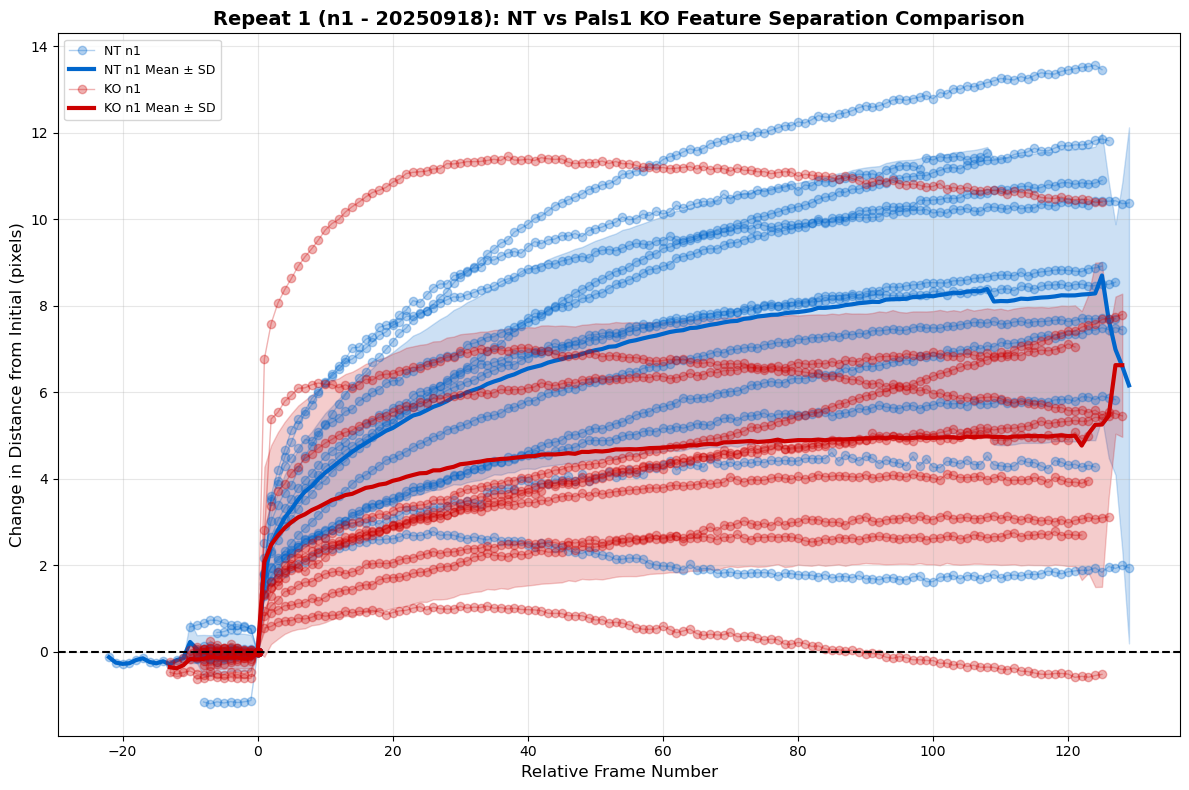


GENERATING REPEAT 2 (n2) COMPARISON FIGURE...
✓ Figure saved: Repeat2_n2_NT_vs_Pals1KO_Comparison.png


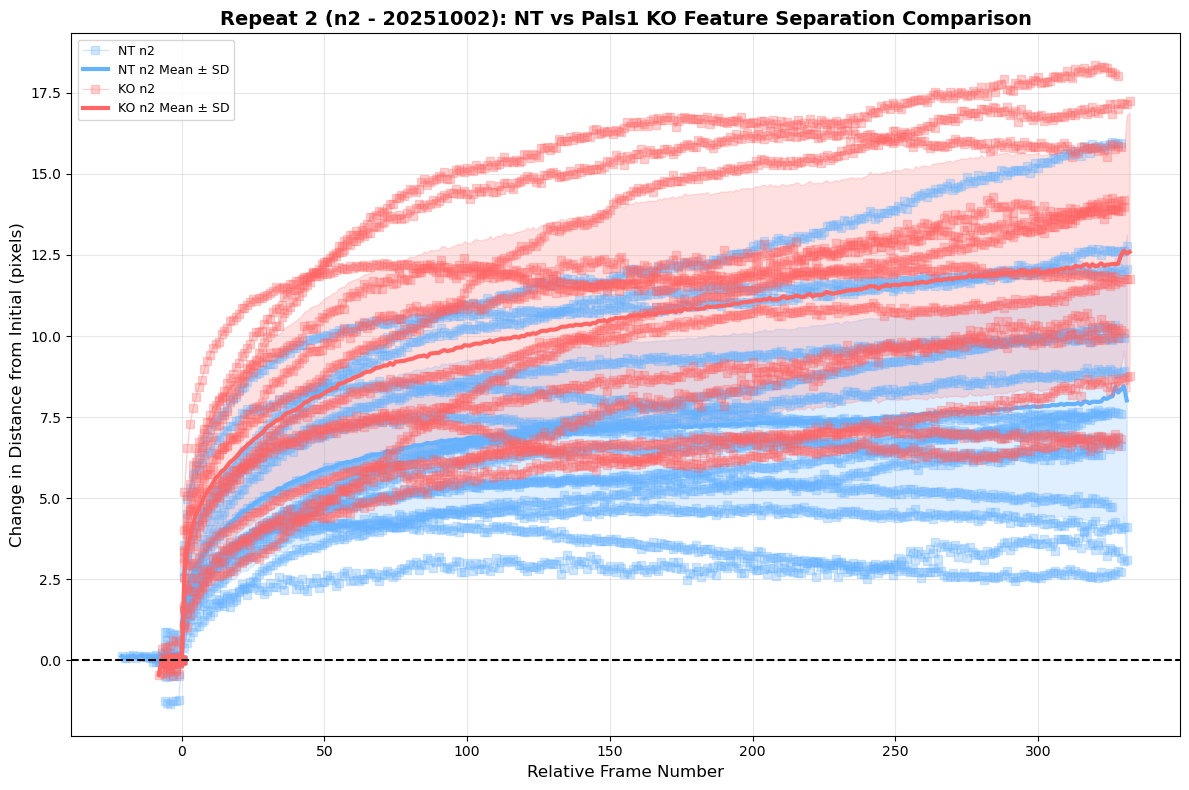


GENERATING REPEAT 3 (n3) COMPARISON FIGURE...
✓ Figure saved: Repeat3_n3_NT_vs_Pals1KO_Comparison.png


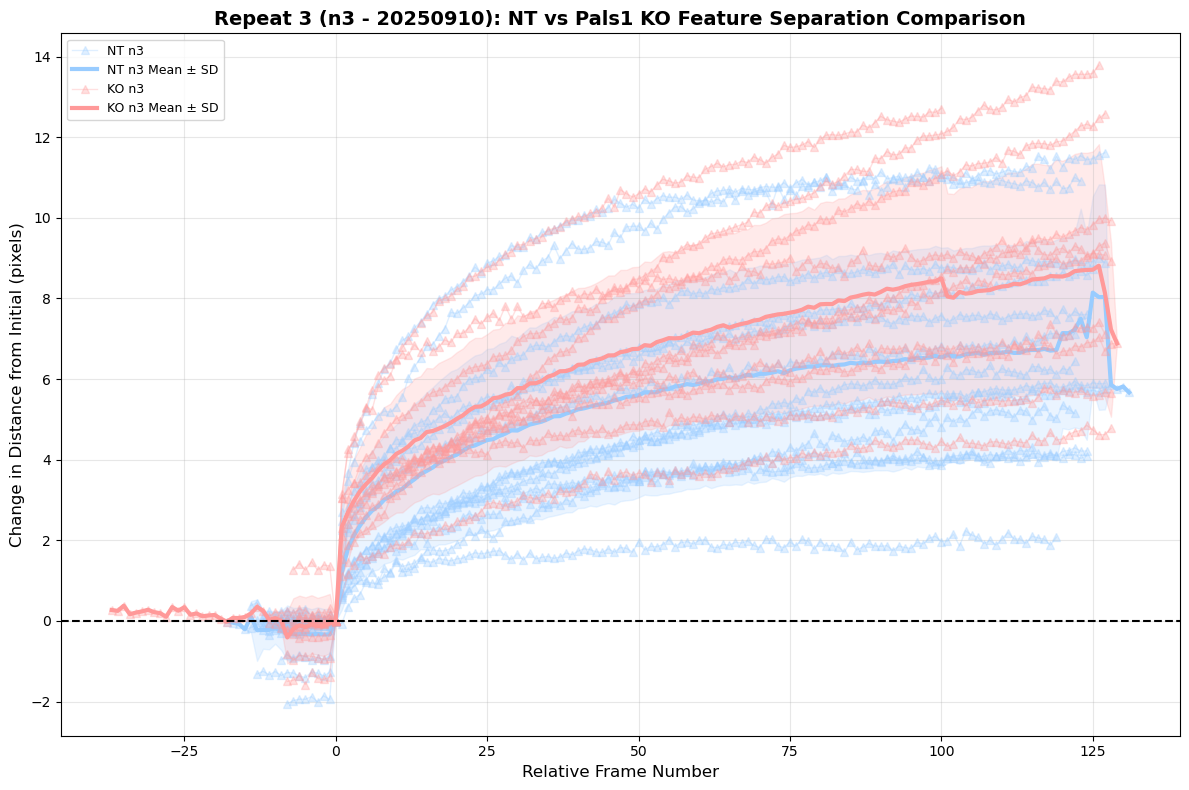


GENERATING COMBINED COMPARISON FIGURE...
✓ Figure saved: NT_vs_Pals1KO_Feature_Separation_Comparison.png


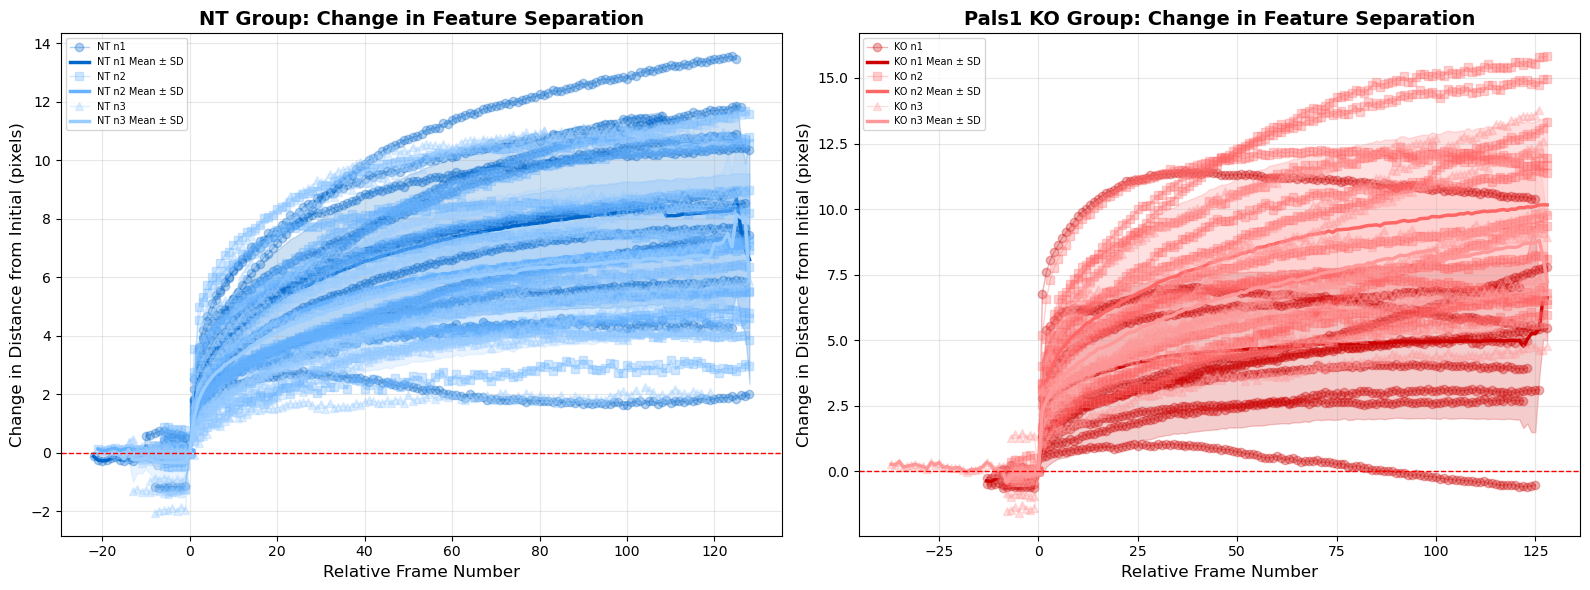


Generating overlay comparison plot...
✓ Figure saved: NT_vs_Pals1KO_Overlay_Comparison.png


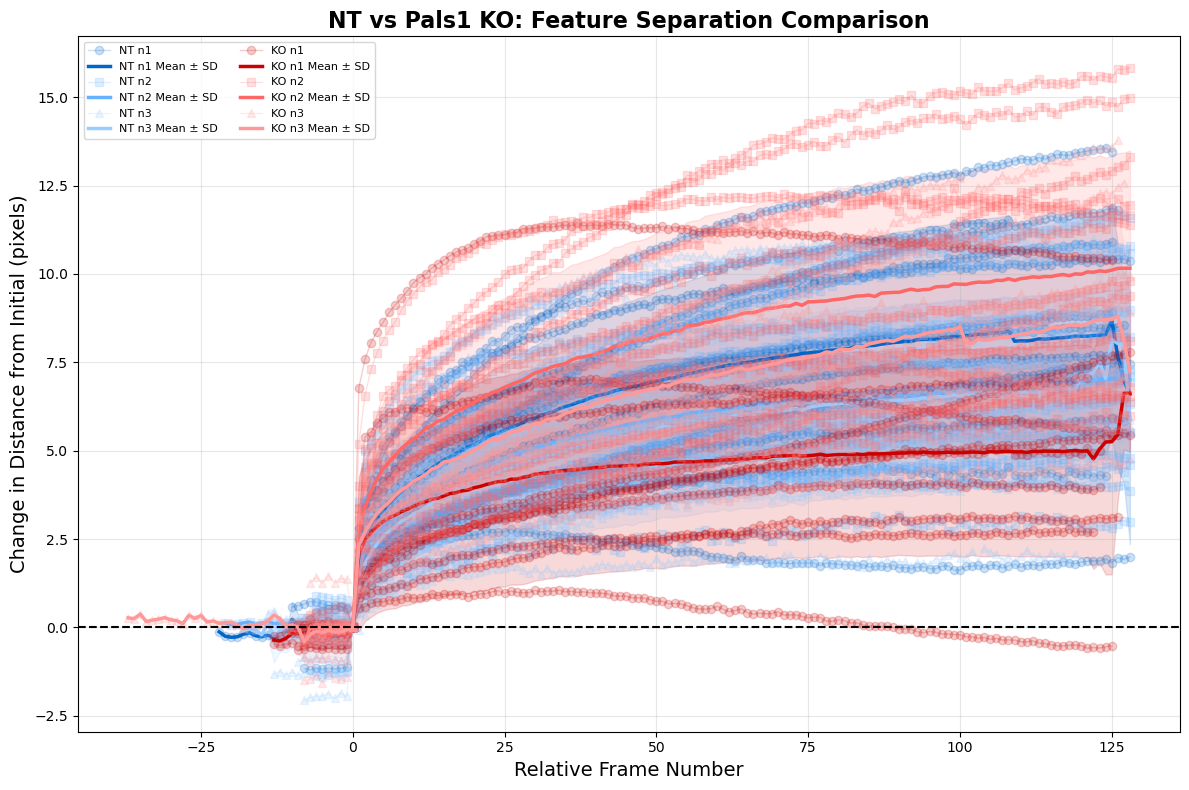


Generating separate mean time course comparison plot...
✓ Figure saved: NT_vs_Pals1KO_Mean_TimeCourse_Comparison.png


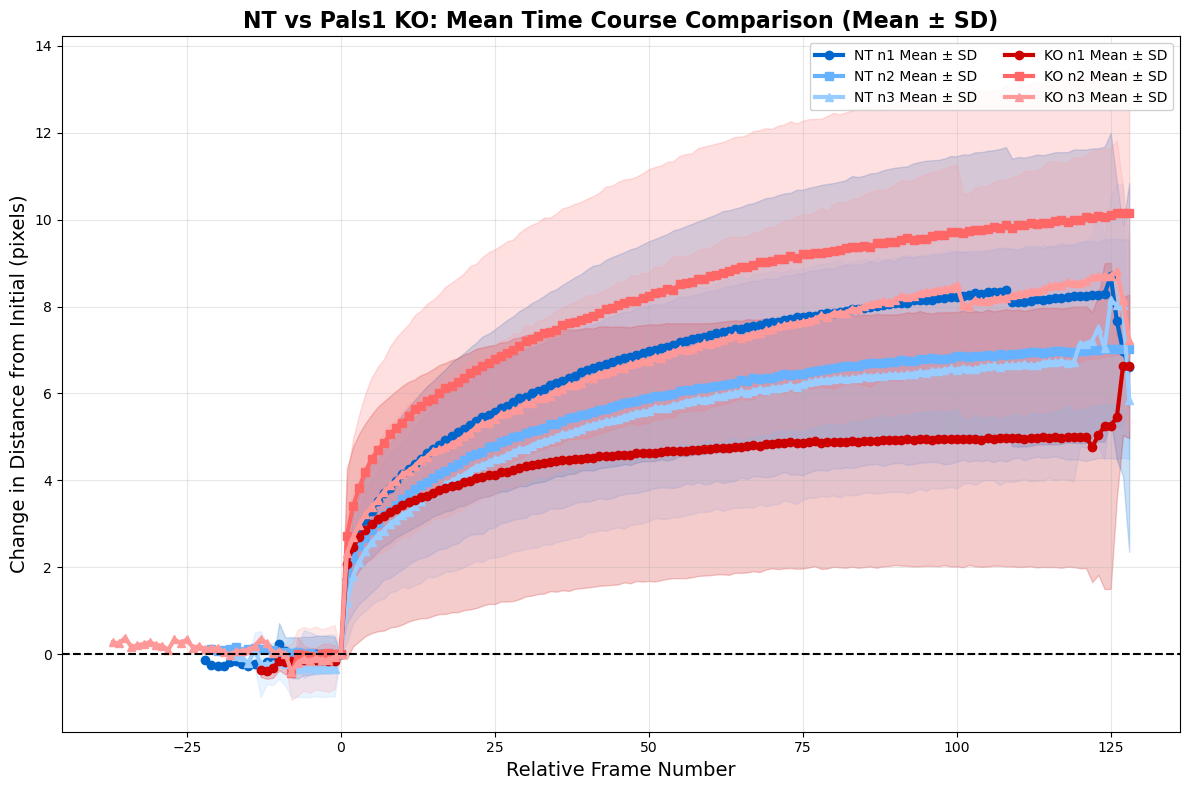


GENERATING GRAND MEAN TIME COURSE COMPARISON...
✓ Figure saved: NT_vs_Pals1KO_GrandMean_TimeCourse_Comparison.png


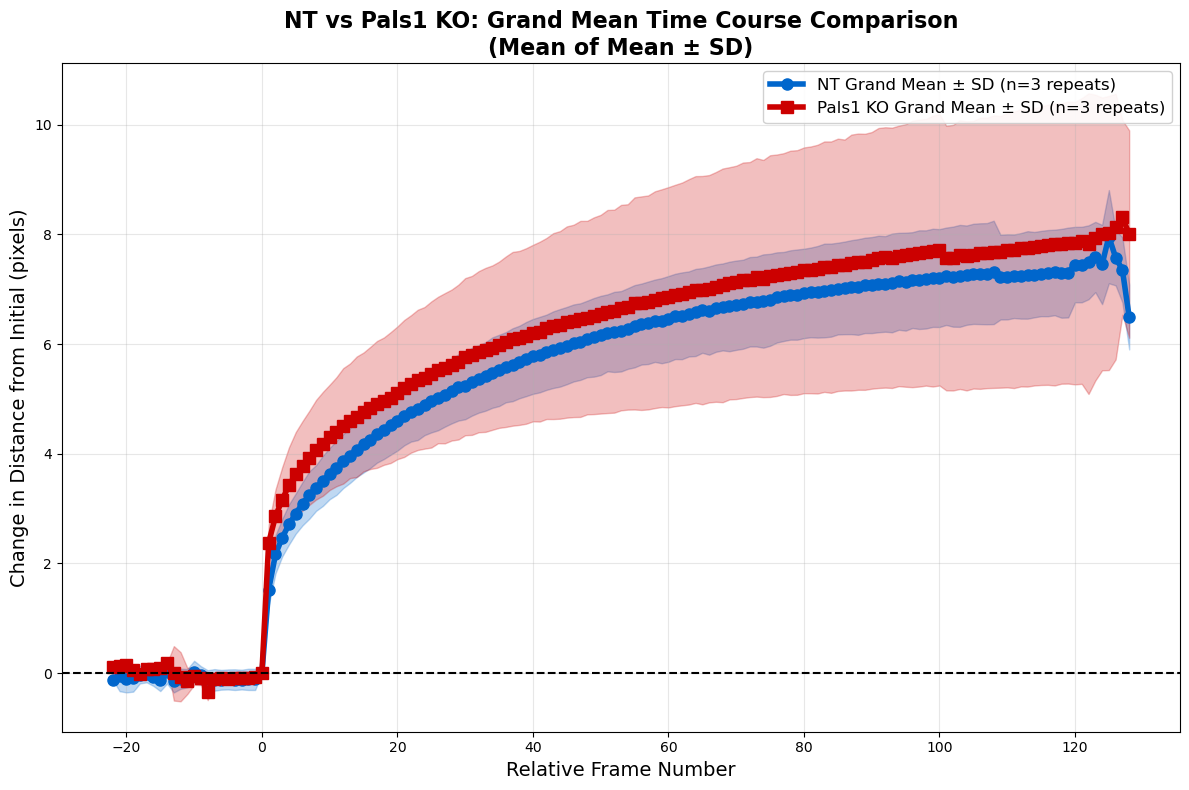


✅ COMPARISON ANALYSIS COMPLETE!


In [3]:
# ============================================================================
# COMPARE FEATURE SEPARATION BETWEEN NT AND PALS1 KO GROUPS
# ============================================================================
# This cell analyzes all exported CSV files and compares feature separation
# changes between NT and Pals1 KO groups
# ============================================================================

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Find the directory where export folders are stored
# Assuming exports are in the same directory as this notebook
notebook_dir = Path("/Users/apple/Desktop/Ian_lab/python_script/ablation assay python")
print(f"Searching for export folders in: {notebook_dir}\n")

# Find all export directories
all_export_dirs = [d for d in notebook_dir.glob("*_exports") if d.is_dir()]
print(f"Found {len(all_export_dirs)} export folders total\n")

# Group samples by repeat and condition
# Repeat 1 (n1): starts with "20250918_"
# Repeat 2 (n2): starts with "20251002_"
# Repeat 3 (n3): starts with "20250910_"

# NT samples
nt_n1_pattern = "20250918_NT1c5-ZO1-CB650-TJ_72h_"
nt_n2_pattern = "20251002_NT1c5-ZO1-CB650-TJ_72h_"
nt_n3_pattern = "20250910_MMEC_NT1c5-ZO1-CB650-TJ_"
nt_n1_dirs = [d for d in all_export_dirs if nt_n1_pattern in d.name]
nt_n2_dirs = [d for d in all_export_dirs if nt_n2_pattern in d.name]
nt_n3_dirs = [d for d in all_export_dirs if nt_n3_pattern in d.name]

# Pals1 KO samples
ko_n1_pattern = "20250918_KOPals1_sg14-ZO1-CB650-TJ_72h_"
ko_n2_pattern = "20251002_KOsg1.4-ZO1-CB650-TJ_72h_"
ko_n3_pattern = "20250910_KOPals1-sg1c4-ZO1-CB650-TJ_"
ko_n1_dirs = [d for d in all_export_dirs if ko_n1_pattern in d.name]
ko_n2_dirs = [d for d in all_export_dirs if ko_n2_pattern in d.name]
ko_n3_dirs = [d for d in all_export_dirs if ko_n3_pattern in d.name]

print(f"NT Repeat 1 (n1 - 20250918): {len(nt_n1_dirs)} samples")
for d in nt_n1_dirs:
    print(f"  - {d.name}")

print(f"\nNT Repeat 2 (n2 - 20251002): {len(nt_n2_dirs)} samples")
for d in nt_n2_dirs:
    print(f"  - {d.name}")

print(f"\nNT Repeat 3 (n3 - 20250910): {len(nt_n3_dirs)} samples")
for d in nt_n3_dirs:
    print(f"  - {d.name}")

print(f"\nPals1 KO Repeat 1 (n1 - 20250918): {len(ko_n1_dirs)} samples")
for d in ko_n1_dirs:
    print(f"  - {d.name}")

print(f"\nPals1 KO Repeat 2 (n2 - 20251002): {len(ko_n2_dirs)} samples")
for d in ko_n2_dirs:
    print(f"  - {d.name}")

print(f"\nPals1 KO Repeat 3 (n3 - 20250910): {len(ko_n3_dirs)} samples")
for d in ko_n3_dirs:
    print(f"  - {d.name}")

# Function to load tracking data and calculate distance change
def load_distance_change_data(export_dir):
    """
    Load tracking results CSV and calculate distance change from initial
    
    Returns:
    - DataFrame with Relative Frame and Distance Change columns
    """
    # Find the CSV file in the export directory
    csv_files = list(export_dir.glob("*_tracking_results.csv"))
    
    if len(csv_files) == 0:
        print(f"⚠️  No CSV file found in {export_dir.name}")
        return None
    
    csv_path = csv_files[0]
    
    # Read CSV
    df = pd.read_csv(csv_path)
    
    # Get initial distance (at relative frame 0)
    initial_row = df[df['Relative Frame'] == 0]
    if len(initial_row) == 0:
        print(f"⚠️  No frame 0 found in {csv_path.name}")
        return None
    
    initial_distance = initial_row['Feature Distance'].values[0]
    
    # Calculate distance change
    df['Distance Change'] = df['Feature Distance'] - initial_distance
    
    return df[['Relative Frame', 'Distance Change']]

# Load data for all samples
print("\n" + "="*70)
print("LOADING DATA...")
print("="*70)

# Load data for each group and repeat
nt_n1_data = []
for export_dir in nt_n1_dirs:
    df = load_distance_change_data(export_dir)
    if df is not None:
        nt_n1_data.append({
            'name': export_dir.name,
            'data': df
        })
        print(f"✓ Loaded: {export_dir.name}")

nt_n2_data = []
for export_dir in nt_n2_dirs:
    df = load_distance_change_data(export_dir)
    if df is not None:
        nt_n2_data.append({
            'name': export_dir.name,
            'data': df
        })
        print(f"✓ Loaded: {export_dir.name}")

nt_n3_data = []
for export_dir in nt_n3_dirs:
    df = load_distance_change_data(export_dir)
    if df is not None:
        nt_n3_data.append({
            'name': export_dir.name,
            'data': df
        })
        print(f"✓ Loaded: {export_dir.name}")

ko_n1_data = []
for export_dir in ko_n1_dirs:
    df = load_distance_change_data(export_dir)
    if df is not None:
        ko_n1_data.append({
            'name': export_dir.name,
            'data': df
        })
        print(f"✓ Loaded: {export_dir.name}")

ko_n2_data = []
for export_dir in ko_n2_dirs:
    df = load_distance_change_data(export_dir)
    if df is not None:
        ko_n2_data.append({
            'name': export_dir.name,
            'data': df
        })
        print(f"✓ Loaded: {export_dir.name}")

ko_n3_data = []
for export_dir in ko_n3_dirs:
    df = load_distance_change_data(export_dir)
    if df is not None:
        ko_n3_data.append({
            'name': export_dir.name,
            'data': df
        })
        print(f"✓ Loaded: {export_dir.name}")

print(f"\n✅ Successfully loaded:")
print(f"   NT n1: {len(nt_n1_data)} samples")
print(f"   NT n2: {len(nt_n2_data)} samples")
print(f"   NT n3: {len(nt_n3_data)} samples")
print(f"   Pals1 KO n1: {len(ko_n1_data)} samples")
print(f"   Pals1 KO n2: {len(ko_n2_data)} samples")
print(f"   Pals1 KO n3: {len(ko_n3_data)} samples")

# ============================================================================
# DETERMINE THE SHORTEST MAX RELATIVE FRAME ACROSS ALL REPEATS
# ============================================================================
print("\n" + "="*70)
print("DETERMINING SHORTEST MAX RELATIVE FRAME NUMBER...")
print("="*70)

# Find max relative frame for each repeat
all_data_groups = [nt_n1_data, nt_n2_data, nt_n3_data, ko_n1_data, ko_n2_data, ko_n3_data]
repeat_max_frames = []

for group_name, data_group in zip(['NT n1', 'NT n2', 'NT n3', 'KO n1', 'KO n2', 'KO n3'], all_data_groups):
    if len(data_group) > 0:
        max_frame = max([sample['data']['Relative Frame'].max() for sample in data_group])
        repeat_max_frames.append(max_frame)
        print(f"{group_name}: max relative frame = {max_frame}")

# Use the minimum of all max frames
if len(repeat_max_frames) > 0:
    common_max_frame = min(repeat_max_frames)
    print(f"\n✓ Using common max relative frame: {common_max_frame}")
    print(f"  (shortest among all repeats to ensure consistent comparison)")
else:
    common_max_frame = None
    print("\n⚠️ No data available to determine max frame")

# Define colors for each repeat within each group
# NT group: blue shades
nt_n1_color = '#0066CC'  # Darker blue for repeat 1
nt_n2_color = '#66B2FF'  # Lighter blue for repeat 2
nt_n3_color = '#99CCFF'  # Even lighter blue for repeat 3

# Pals1 KO group: red shades
ko_n1_color = '#CC0000'  # Darker red for repeat 1
ko_n2_color = '#FF6666'  # Lighter red for repeat 2
ko_n3_color = '#FF9999'  # Even lighter red for repeat 3

# ============================================================================
# HELPER FUNCTION TO CALCULATE MEAN AND SD TIME COURSE
# ============================================================================

def calculate_mean_sd_timecourse(data_list, max_frame=None):
    """
    Calculate mean and standard deviation at each time point across all samples
    
    Parameters:
    - data_list: List of dictionaries with 'data' key containing DataFrame
    - max_frame: Maximum relative frame to include (optional)
    
    Returns:
    - frames: Array of relative frame numbers
    - means: Mean distance change at each frame
    - stds: Standard deviation at each frame
    """
    if len(data_list) == 0:
        return np.array([]), np.array([]), np.array([])
    
    # Get all unique frames across all samples
    all_frames = set()
    for sample in data_list:
        df = sample['data']
        if max_frame is not None:
            df = df[df['Relative Frame'] <= max_frame]
        all_frames.update(df['Relative Frame'].values)
    
    frames = np.array(sorted(all_frames))
    means = []
    stds = []
    
    for frame in frames:
        values = []
        for sample in data_list:
            df = sample['data']
            frame_data = df[df['Relative Frame'] == frame]['Distance Change']
            if len(frame_data) > 0:
                values.append(frame_data.values[0])
        
        if len(values) > 0:
            means.append(np.mean(values))
            stds.append(np.std(values, ddof=1) if len(values) > 1 else 0)
        else:
            means.append(np.nan)
            stds.append(np.nan)
    
    return frames, np.array(means), np.array(stds)

# ============================================================================
# INDIVIDUAL COMPARISON FIGURES FOR EACH REPEAT
# ============================================================================

# Plot comparison for Repeat 1 (n1 - 20250918)
print("\n" + "="*70)
print("GENERATING REPEAT 1 (n1) COMPARISON FIGURE...")
print("="*70)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot NT repeat 1
for i, sample in enumerate(nt_n1_data):
    ax.plot(sample['data']['Relative Frame'], 
            sample['data']['Distance Change'], 
            marker='o', 
            color=nt_n1_color,
            alpha=0.3,
            linewidth=1,
            label="NT n1" if i == 0 else "")

# Calculate and plot mean ± SD for NT repeat 1
nt_n1_frames, nt_n1_means, nt_n1_stds = calculate_mean_sd_timecourse(nt_n1_data)
ax.plot(nt_n1_frames, nt_n1_means, 
        color=nt_n1_color, linewidth=3, 
        label="NT n1 Mean ± SD")
ax.fill_between(nt_n1_frames, 
                nt_n1_means - nt_n1_stds, 
                nt_n1_means + nt_n1_stds, 
                color=nt_n1_color, alpha=0.2)

# Plot Pals1 KO repeat 1
for i, sample in enumerate(ko_n1_data):
    ax.plot(sample['data']['Relative Frame'], 
            sample['data']['Distance Change'], 
            marker='o', 
            color=ko_n1_color,
            alpha=0.3,
            linewidth=1,
            label="KO n1" if i == 0 else "")

# Calculate and plot mean ± SD for KO repeat 1
ko_n1_frames, ko_n1_means, ko_n1_stds = calculate_mean_sd_timecourse(ko_n1_data)
ax.plot(ko_n1_frames, ko_n1_means, 
        color=ko_n1_color, linewidth=3, 
        label="KO n1 Mean ± SD")
ax.fill_between(ko_n1_frames, 
                ko_n1_means - ko_n1_stds, 
                ko_n1_means + ko_n1_stds, 
                color=ko_n1_color, alpha=0.2)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
ax.set_title('Repeat 1 (n1 - 20250918): NT vs Pals1 KO Feature Separation Comparison', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Relative Frame Number', fontsize=12)
ax.set_ylabel('Change in Distance from Initial (pixels)', fontsize=12)
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(notebook_dir / "Repeat1_n1_NT_vs_Pals1KO_Comparison.png", dpi=300, bbox_inches='tight')
print("✓ Figure saved: Repeat1_n1_NT_vs_Pals1KO_Comparison.png")
plt.show()

# Plot comparison for Repeat 2 (n2 - 20251002)
print("\n" + "="*70)
print("GENERATING REPEAT 2 (n2) COMPARISON FIGURE...")
print("="*70)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot NT repeat 2
for i, sample in enumerate(nt_n2_data):
    ax.plot(sample['data']['Relative Frame'], 
            sample['data']['Distance Change'], 
            marker='s', 
            color=nt_n2_color,
            alpha=0.3,
            linewidth=1,
            label="NT n2" if i == 0 else "")

# Calculate and plot mean ± SD for NT repeat 2
nt_n2_frames, nt_n2_means, nt_n2_stds = calculate_mean_sd_timecourse(nt_n2_data)
ax.plot(nt_n2_frames, nt_n2_means, 
        color=nt_n2_color, linewidth=3, 
        label="NT n2 Mean ± SD")
ax.fill_between(nt_n2_frames, 
                nt_n2_means - nt_n2_stds, 
                nt_n2_means + nt_n2_stds, 
                color=nt_n2_color, alpha=0.2)

# Plot Pals1 KO repeat 2
for i, sample in enumerate(ko_n2_data):
    ax.plot(sample['data']['Relative Frame'], 
            sample['data']['Distance Change'], 
            marker='s', 
            color=ko_n2_color,
            alpha=0.3,
            linewidth=1,
            label="KO n2" if i == 0 else "")

# Calculate and plot mean ± SD for KO repeat 2
ko_n2_frames, ko_n2_means, ko_n2_stds = calculate_mean_sd_timecourse(ko_n2_data)
ax.plot(ko_n2_frames, ko_n2_means, 
        color=ko_n2_color, linewidth=3, 
        label="KO n2 Mean ± SD")
ax.fill_between(ko_n2_frames, 
                ko_n2_means - ko_n2_stds, 
                ko_n2_means + ko_n2_stds, 
                color=ko_n2_color, alpha=0.2)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
ax.set_title('Repeat 2 (n2 - 20251002): NT vs Pals1 KO Feature Separation Comparison', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Relative Frame Number', fontsize=12)
ax.set_ylabel('Change in Distance from Initial (pixels)', fontsize=12)
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(notebook_dir / "Repeat2_n2_NT_vs_Pals1KO_Comparison.png", dpi=300, bbox_inches='tight')
print("✓ Figure saved: Repeat2_n2_NT_vs_Pals1KO_Comparison.png")
plt.show()

# Plot comparison for Repeat 3 (n3 - 20250910)
print("\n" + "="*70)
print("GENERATING REPEAT 3 (n3) COMPARISON FIGURE...")
print("="*70)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot NT repeat 3
for i, sample in enumerate(nt_n3_data):
    ax.plot(sample['data']['Relative Frame'], 
            sample['data']['Distance Change'], 
            marker='^', 
            color=nt_n3_color,
            alpha=0.3,
            linewidth=1,
            label="NT n3" if i == 0 else "")

# Calculate and plot mean ± SD for NT repeat 3
nt_n3_frames, nt_n3_means, nt_n3_stds = calculate_mean_sd_timecourse(nt_n3_data)
ax.plot(nt_n3_frames, nt_n3_means, 
        color=nt_n3_color, linewidth=3, 
        label="NT n3 Mean ± SD")
ax.fill_between(nt_n3_frames, 
                nt_n3_means - nt_n3_stds, 
                nt_n3_means + nt_n3_stds, 
                color=nt_n3_color, alpha=0.2)

# Plot Pals1 KO repeat 3
for i, sample in enumerate(ko_n3_data):
    ax.plot(sample['data']['Relative Frame'], 
            sample['data']['Distance Change'], 
            marker='^', 
            color=ko_n3_color,
            alpha=0.3,
            linewidth=1,
            label="KO n3" if i == 0 else "")

# Calculate and plot mean ± SD for KO repeat 3
ko_n3_frames, ko_n3_means, ko_n3_stds = calculate_mean_sd_timecourse(ko_n3_data)
ax.plot(ko_n3_frames, ko_n3_means, 
        color=ko_n3_color, linewidth=3, 
        label="KO n3 Mean ± SD")
ax.fill_between(ko_n3_frames, 
                ko_n3_means - ko_n3_stds, 
                ko_n3_means + ko_n3_stds, 
                color=ko_n3_color, alpha=0.2)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
ax.set_title('Repeat 3 (n3 - 20250910): NT vs Pals1 KO Feature Separation Comparison', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Relative Frame Number', fontsize=12)
ax.set_ylabel('Change in Distance from Initial (pixels)', fontsize=12)
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(notebook_dir / "Repeat3_n3_NT_vs_Pals1KO_Comparison.png", dpi=300, bbox_inches='tight')
print("✓ Figure saved: Repeat3_n3_NT_vs_Pals1KO_Comparison.png")
plt.show()

# ============================================================================
# COMBINED COMPARISON FIGURE WITH ALL REPEATS
# ============================================================================

print("\n" + "="*70)
print("GENERATING COMBINED COMPARISON FIGURE...")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Group 1 (NT)
ax1 = axes[0]

# NT repeat 1 (n1) - filter by common_max_frame
for i, sample in enumerate(nt_n1_data):
    df_filtered = sample['data'][sample['data']['Relative Frame'] <= common_max_frame]
    ax1.plot(df_filtered['Relative Frame'], 
             df_filtered['Distance Change'], 
             marker='o', 
             color=nt_n1_color,
             alpha=0.3,
             linewidth=1,
             label="NT n1" if i == 0 else "")

# Calculate and plot mean ± SD for NT repeat 1
nt_n1_frames, nt_n1_means, nt_n1_stds = calculate_mean_sd_timecourse(nt_n1_data, max_frame=common_max_frame)
ax1.plot(nt_n1_frames, nt_n1_means, 
         color=nt_n1_color, linewidth=2.5, 
         label="NT n1 Mean ± SD")
ax1.fill_between(nt_n1_frames, 
                 nt_n1_means - nt_n1_stds, 
                 nt_n1_means + nt_n1_stds, 
                 color=nt_n1_color, alpha=0.2)

# NT repeat 2 (n2) - filter by common_max_frame
for i, sample in enumerate(nt_n2_data):
    df_filtered = sample['data'][sample['data']['Relative Frame'] <= common_max_frame]
    ax1.plot(df_filtered['Relative Frame'], 
             df_filtered['Distance Change'], 
             marker='s',
             color=nt_n2_color,
             alpha=0.3,
             linewidth=1,
             label="NT n2" if i == 0 else "")

# Calculate and plot mean ± SD for NT repeat 2
nt_n2_frames, nt_n2_means, nt_n2_stds = calculate_mean_sd_timecourse(nt_n2_data, max_frame=common_max_frame)
ax1.plot(nt_n2_frames, nt_n2_means, 
         color=nt_n2_color, linewidth=2.5, 
         label="NT n2 Mean ± SD")
ax1.fill_between(nt_n2_frames, 
                 nt_n2_means - nt_n2_stds, 
                 nt_n2_means + nt_n2_stds, 
                 color=nt_n2_color, alpha=0.2)

# NT repeat 3 (n3) - filter by common_max_frame
for i, sample in enumerate(nt_n3_data):
    df_filtered = sample['data'][sample['data']['Relative Frame'] <= common_max_frame]
    ax1.plot(df_filtered['Relative Frame'], 
             df_filtered['Distance Change'], 
             marker='^',
             color=nt_n3_color,
             alpha=0.3,
             linewidth=1,
             label="NT n3" if i == 0 else "")

# Calculate and plot mean ± SD for NT repeat 3
nt_n3_frames, nt_n3_means, nt_n3_stds = calculate_mean_sd_timecourse(nt_n3_data, max_frame=common_max_frame)
ax1.plot(nt_n3_frames, nt_n3_means, 
         color=nt_n3_color, linewidth=2.5, 
         label="NT n3 Mean ± SD")
ax1.fill_between(nt_n3_frames, 
                 nt_n3_means - nt_n3_stds, 
                 nt_n3_means + nt_n3_stds, 
                 color=nt_n3_color, alpha=0.2)

ax1.axhline(y=0, color='r', linestyle='--', linewidth=1)
ax1.set_title('NT Group: Change in Feature Separation', fontsize=14, fontweight='bold')
ax1.set_xlabel('Relative Frame Number', fontsize=12)
ax1.set_ylabel('Change in Distance from Initial (pixels)', fontsize=12)
ax1.legend(fontsize=7, loc='best')
ax1.grid(True, alpha=0.3)

# Plot Group 2 (Pals1 KO)
ax2 = axes[1]

# Pals1 KO repeat 1 (n1) - filter by common_max_frame
for i, sample in enumerate(ko_n1_data):
    df_filtered = sample['data'][sample['data']['Relative Frame'] <= common_max_frame]
    ax2.plot(df_filtered['Relative Frame'], 
             df_filtered['Distance Change'], 
             marker='o', 
             color=ko_n1_color,
             alpha=0.3,
             linewidth=1,
             label="KO n1" if i == 0 else "")

# Calculate and plot mean ± SD for KO repeat 1
ko_n1_frames, ko_n1_means, ko_n1_stds = calculate_mean_sd_timecourse(ko_n1_data, max_frame=common_max_frame)
ax2.plot(ko_n1_frames, ko_n1_means, 
         color=ko_n1_color, linewidth=2.5, 
         label="KO n1 Mean ± SD")
ax2.fill_between(ko_n1_frames, 
                 ko_n1_means - ko_n1_stds, 
                 ko_n1_means + ko_n1_stds, 
                 color=ko_n1_color, alpha=0.2)

# Pals1 KO repeat 2 (n2) - filter by common_max_frame
for i, sample in enumerate(ko_n2_data):
    df_filtered = sample['data'][sample['data']['Relative Frame'] <= common_max_frame]
    ax2.plot(df_filtered['Relative Frame'], 
             df_filtered['Distance Change'], 
             marker='s',
             color=ko_n2_color,
             alpha=0.3,
             linewidth=1,
             label="KO n2" if i == 0 else "")

# Calculate and plot mean ± SD for KO repeat 2
ko_n2_frames, ko_n2_means, ko_n2_stds = calculate_mean_sd_timecourse(ko_n2_data, max_frame=common_max_frame)
ax2.plot(ko_n2_frames, ko_n2_means, 
         color=ko_n2_color, linewidth=2.5, 
         label="KO n2 Mean ± SD")
ax2.fill_between(ko_n2_frames, 
                 ko_n2_means - ko_n2_stds, 
                 ko_n2_means + ko_n2_stds, 
                 color=ko_n2_color, alpha=0.2)

# Pals1 KO repeat 3 (n3) - filter by common_max_frame
for i, sample in enumerate(ko_n3_data):
    df_filtered = sample['data'][sample['data']['Relative Frame'] <= common_max_frame]
    ax2.plot(df_filtered['Relative Frame'], 
             df_filtered['Distance Change'], 
             marker='^',
             color=ko_n3_color,
             alpha=0.3,
             linewidth=1,
             label="KO n3" if i == 0 else "")

# Calculate and plot mean ± SD for KO repeat 3
ko_n3_frames, ko_n3_means, ko_n3_stds = calculate_mean_sd_timecourse(ko_n3_data, max_frame=common_max_frame)
ax2.plot(ko_n3_frames, ko_n3_means, 
         color=ko_n3_color, linewidth=2.5, 
         label="KO n3 Mean ± SD")
ax2.fill_between(ko_n3_frames, 
                 ko_n3_means - ko_n3_stds, 
                 ko_n3_means + ko_n3_stds, 
                 color=ko_n3_color, alpha=0.2)

ax2.axhline(y=0, color='r', linestyle='--', linewidth=1)
ax2.set_title('Pals1 KO Group: Change in Feature Separation', fontsize=14, fontweight='bold')
ax2.set_xlabel('Relative Frame Number', fontsize=12)
ax2.set_ylabel('Change in Distance from Initial (pixels)', fontsize=12)
ax2.legend(fontsize=7, loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(notebook_dir / "NT_vs_Pals1KO_Feature_Separation_Comparison.png", dpi=300, bbox_inches='tight')
print("✓ Figure saved: NT_vs_Pals1KO_Feature_Separation_Comparison.png")
plt.show()

# Also create an overlay comparison plot
print("\nGenerating overlay comparison plot...")
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot NT repeat 1 (n1) in darker blue - filter by common_max_frame
for i, sample in enumerate(nt_n1_data):
    df_filtered = sample['data'][sample['data']['Relative Frame'] <= common_max_frame]
    ax.plot(df_filtered['Relative Frame'], 
            df_filtered['Distance Change'], 
            marker='o', 
            color=nt_n1_color,
            alpha=0.2,
            linewidth=1,
            label="NT n1" if i == 0 else "")

# Calculate and plot mean ± SD for NT repeat 1
ax.plot(nt_n1_frames, nt_n1_means, 
        color=nt_n1_color, linewidth=2.5, 
        label="NT n1 Mean ± SD")
ax.fill_between(nt_n1_frames, 
                nt_n1_means - nt_n1_stds, 
                nt_n1_means + nt_n1_stds, 
                color=nt_n1_color, alpha=0.15)

# Plot NT repeat 2 (n2) in lighter blue - filter by common_max_frame
for i, sample in enumerate(nt_n2_data):
    df_filtered = sample['data'][sample['data']['Relative Frame'] <= common_max_frame]
    ax.plot(df_filtered['Relative Frame'], 
            df_filtered['Distance Change'], 
            marker='s', 
            color=nt_n2_color,
            alpha=0.2,
            linewidth=1,
            label="NT n2" if i == 0 else "")

# Calculate and plot mean ± SD for NT repeat 2
ax.plot(nt_n2_frames, nt_n2_means, 
        color=nt_n2_color, linewidth=2.5, 
        label="NT n2 Mean ± SD")
ax.fill_between(nt_n2_frames, 
                nt_n2_means - nt_n2_stds, 
                nt_n2_means + nt_n2_stds, 
                color=nt_n2_color, alpha=0.15)

# Plot NT repeat 3 (n3) in even lighter blue - filter by common_max_frame
for i, sample in enumerate(nt_n3_data):
    df_filtered = sample['data'][sample['data']['Relative Frame'] <= common_max_frame]
    ax.plot(df_filtered['Relative Frame'], 
            df_filtered['Distance Change'], 
            marker='^', 
            color=nt_n3_color,
            alpha=0.2,
            linewidth=1,
            label="NT n3" if i == 0 else "")

# Calculate and plot mean ± SD for NT repeat 3
ax.plot(nt_n3_frames, nt_n3_means, 
        color=nt_n3_color, linewidth=2.5, 
        label="NT n3 Mean ± SD")
ax.fill_between(nt_n3_frames, 
                nt_n3_means - nt_n3_stds, 
                nt_n3_means + nt_n3_stds, 
                color=nt_n3_color, alpha=0.15)

# Plot Pals1 KO repeat 1 (n1) in darker red - filter by common_max_frame
for i, sample in enumerate(ko_n1_data):
    df_filtered = sample['data'][sample['data']['Relative Frame'] <= common_max_frame]
    ax.plot(df_filtered['Relative Frame'], 
            df_filtered['Distance Change'], 
            marker='o', 
            color=ko_n1_color,
            alpha=0.2,
            linewidth=1,
            label="KO n1" if i == 0 else "")

# Calculate and plot mean ± SD for KO repeat 1
ax.plot(ko_n1_frames, ko_n1_means, 
        color=ko_n1_color, linewidth=2.5, 
        label="KO n1 Mean ± SD")
ax.fill_between(ko_n1_frames, 
                ko_n1_means - ko_n1_stds, 
                ko_n1_means + ko_n1_stds, 
                color=ko_n1_color, alpha=0.15)

# Plot Pals1 KO repeat 2 (n2) in lighter red - filter by common_max_frame
for i, sample in enumerate(ko_n2_data):
    df_filtered = sample['data'][sample['data']['Relative Frame'] <= common_max_frame]
    ax.plot(df_filtered['Relative Frame'], 
            df_filtered['Distance Change'], 
            marker='s', 
            color=ko_n2_color,
            alpha=0.2,
            linewidth=1,
            label="KO n2" if i == 0 else "")

# Calculate and plot mean ± SD for KO repeat 2
ax.plot(ko_n2_frames, ko_n2_means, 
        color=ko_n2_color, linewidth=2.5, 
        label="KO n2 Mean ± SD")
ax.fill_between(ko_n2_frames, 
                ko_n2_means - ko_n2_stds, 
                ko_n2_means + ko_n2_stds, 
                color=ko_n2_color, alpha=0.15)

# Plot Pals1 KO repeat 3 (n3) in even lighter red - filter by common_max_frame
for i, sample in enumerate(ko_n3_data):
    df_filtered = sample['data'][sample['data']['Relative Frame'] <= common_max_frame]
    ax.plot(df_filtered['Relative Frame'], 
            df_filtered['Distance Change'], 
            marker='^', 
            color=ko_n3_color,
            alpha=0.2,
            linewidth=1,
            label="KO n3" if i == 0 else "")

# Calculate and plot mean ± SD for KO repeat 3
ax.plot(ko_n3_frames, ko_n3_means, 
        color=ko_n3_color, linewidth=2.5, 
        label="KO n3 Mean ± SD")
ax.fill_between(ko_n3_frames, 
                ko_n3_means - ko_n3_stds, 
                ko_n3_means + ko_n3_stds, 
                color=ko_n3_color, alpha=0.15)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
ax.set_title('NT vs Pals1 KO: Feature Separation Comparison', fontsize=16, fontweight='bold')
ax.set_xlabel('Relative Frame Number', fontsize=14)
ax.set_ylabel('Change in Distance from Initial (pixels)', fontsize=14)
ax.legend(fontsize=8, loc='best', ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(notebook_dir / "NT_vs_Pals1KO_Overlay_Comparison.png", dpi=300, bbox_inches='tight')
print("✓ Figure saved: NT_vs_Pals1KO_Overlay_Comparison.png")
plt.show()

# ============================================================================
# SEPARATE MEAN TIME COURSE COMPARISON (MEAN ± SD ONLY)
# ============================================================================

print("\nGenerating separate mean time course comparison plot...")
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot ONLY mean ± SD for each group (no individual traces)
# NT repeat 1 (n1)
ax.plot(nt_n1_frames, nt_n1_means, 
        color=nt_n1_color, linewidth=3, 
        label="NT n1 Mean ± SD", marker='o', markersize=6)
ax.fill_between(nt_n1_frames, 
                nt_n1_means - nt_n1_stds, 
                nt_n1_means + nt_n1_stds, 
                color=nt_n1_color, alpha=0.2)

# NT repeat 2 (n2)
ax.plot(nt_n2_frames, nt_n2_means, 
        color=nt_n2_color, linewidth=3, 
        label="NT n2 Mean ± SD", marker='s', markersize=6)
ax.fill_between(nt_n2_frames, 
                nt_n2_means - nt_n2_stds, 
                nt_n2_means + nt_n2_stds, 
                color=nt_n2_color, alpha=0.2)

# NT repeat 3 (n3)
ax.plot(nt_n3_frames, nt_n3_means, 
        color=nt_n3_color, linewidth=3, 
        label="NT n3 Mean ± SD", marker='^', markersize=6)
ax.fill_between(nt_n3_frames, 
                nt_n3_means - nt_n3_stds, 
                nt_n3_means + nt_n3_stds, 
                color=nt_n3_color, alpha=0.2)

# Pals1 KO repeat 1 (n1)
ax.plot(ko_n1_frames, ko_n1_means, 
        color=ko_n1_color, linewidth=3, 
        label="KO n1 Mean ± SD", marker='o', markersize=6)
ax.fill_between(ko_n1_frames, 
                ko_n1_means - ko_n1_stds, 
                ko_n1_means + ko_n1_stds, 
                color=ko_n1_color, alpha=0.2)

# Pals1 KO repeat 2 (n2)
ax.plot(ko_n2_frames, ko_n2_means, 
        color=ko_n2_color, linewidth=3, 
        label="KO n2 Mean ± SD", marker='s', markersize=6)
ax.fill_between(ko_n2_frames, 
                ko_n2_means - ko_n2_stds, 
                ko_n2_means + ko_n2_stds, 
                color=ko_n2_color, alpha=0.2)

# Pals1 KO repeat 3 (n3)
ax.plot(ko_n3_frames, ko_n3_means, 
        color=ko_n3_color, linewidth=3, 
        label="KO n3 Mean ± SD", marker='^', markersize=6)
ax.fill_between(ko_n3_frames, 
                ko_n3_means - ko_n3_stds, 
                ko_n3_means + ko_n3_stds, 
                color=ko_n3_color, alpha=0.2)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
ax.set_title('NT vs Pals1 KO: Mean Time Course Comparison (Mean ± SD)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Relative Frame Number', fontsize=14)
ax.set_ylabel('Change in Distance from Initial (pixels)', fontsize=14)
ax.legend(fontsize=10, loc='best', ncol=2, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(notebook_dir / "NT_vs_Pals1KO_Mean_TimeCourse_Comparison.png", dpi=300, bbox_inches='tight')
print("✓ Figure saved: NT_vs_Pals1KO_Mean_TimeCourse_Comparison.png")
plt.show()

# ============================================================================
# GRAND MEAN TIME COURSE COMPARISON (MEAN OF MEANS ± SD)
# ============================================================================

print("\n" + "="*70)
print("GENERATING GRAND MEAN TIME COURSE COMPARISON...")
print("="*70)

# Calculate mean of means and SD across the three repeats for each group
# For NT group: take mean of n1, n2, n3 means at each time point
# For KO group: take mean of n1, n2, n3 means at each time point

# Get all unique frames (should be the same as common_max_frame range)
all_common_frames = nt_n1_frames  # They should all have the same frames after filtering

# Calculate grand mean (mean of means) and grand SD for NT group
nt_grand_means = []
nt_grand_stds = []

for frame in all_common_frames:
    # Get the mean value at this frame for each repeat
    means_at_frame = []
    if frame in nt_n1_frames:
        idx = np.where(nt_n1_frames == frame)[0][0]
        means_at_frame.append(nt_n1_means[idx])
    if frame in nt_n2_frames:
        idx = np.where(nt_n2_frames == frame)[0][0]
        means_at_frame.append(nt_n2_means[idx])
    if frame in nt_n3_frames:
        idx = np.where(nt_n3_frames == frame)[0][0]
        means_at_frame.append(nt_n3_means[idx])
    
    if len(means_at_frame) > 0:
        nt_grand_means.append(np.mean(means_at_frame))
        nt_grand_stds.append(np.std(means_at_frame, ddof=1) if len(means_at_frame) > 1 else 0)
    else:
        nt_grand_means.append(np.nan)
        nt_grand_stds.append(np.nan)

nt_grand_means = np.array(nt_grand_means)
nt_grand_stds = np.array(nt_grand_stds)

# Calculate grand mean (mean of means) and grand SD for KO group
ko_grand_means = []
ko_grand_stds = []

for frame in all_common_frames:
    # Get the mean value at this frame for each repeat
    means_at_frame = []
    if frame in ko_n1_frames:
        idx = np.where(ko_n1_frames == frame)[0][0]
        means_at_frame.append(ko_n1_means[idx])
    if frame in ko_n2_frames:
        idx = np.where(ko_n2_frames == frame)[0][0]
        means_at_frame.append(ko_n2_means[idx])
    if frame in ko_n3_frames:
        idx = np.where(ko_n3_frames == frame)[0][0]
        means_at_frame.append(ko_n3_means[idx])
    
    if len(means_at_frame) > 0:
        ko_grand_means.append(np.mean(means_at_frame))
        ko_grand_stds.append(np.std(means_at_frame, ddof=1) if len(means_at_frame) > 1 else 0)
    else:
        ko_grand_means.append(np.nan)
        ko_grand_stds.append(np.nan)

ko_grand_means = np.array(ko_grand_means)
ko_grand_stds = np.array(ko_grand_stds)

# Define colors for grand means
nt_grand_color = '#0066CC'  # Blue for NT
ko_grand_color = '#CC0000'  # Red for KO

# Create the grand mean comparison plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot NT grand mean (mean of the three repeats' means) ± SD
ax.plot(all_common_frames, nt_grand_means, 
        color=nt_grand_color, linewidth=4, 
        label="NT Grand Mean ± SD (n=3 repeats)", marker='o', markersize=8)
ax.fill_between(all_common_frames, 
                nt_grand_means - nt_grand_stds, 
                nt_grand_means + nt_grand_stds, 
                color=nt_grand_color, alpha=0.25)

# Plot KO grand mean (mean of the three repeats' means) ± SD
ax.plot(all_common_frames, ko_grand_means, 
        color=ko_grand_color, linewidth=4, 
        label="Pals1 KO Grand Mean ± SD (n=3 repeats)", marker='s', markersize=8)
ax.fill_between(all_common_frames, 
                ko_grand_means - ko_grand_stds, 
                ko_grand_means + ko_grand_stds, 
                color=ko_grand_color, alpha=0.25)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
ax.set_title('NT vs Pals1 KO: Grand Mean Time Course Comparison\n(Mean of Mean ± SD)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Relative Frame Number', fontsize=14)
ax.set_ylabel('Change in Distance from Initial (pixels)', fontsize=14)
ax.legend(fontsize=12, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(notebook_dir / "NT_vs_Pals1KO_GrandMean_TimeCourse_Comparison.png", dpi=300, bbox_inches='tight')
print("✓ Figure saved: NT_vs_Pals1KO_GrandMean_TimeCourse_Comparison.png")
plt.show()

print("\n" + "="*70)
print("✅ COMPARISON ANALYSIS COMPLETE!")
print("="*70)

CALCULATING INITIAL RATE OF FEATURE SEPARATION
Using rate between relative frame 0 and frame 2 (actual frame 0 and frame 1)

Calculating rates for NT samples...
  NT n1: 1.1377 pixels/frame
  NT n1: 1.3272 pixels/frame
  NT n1: 1.5064 pixels/frame
  NT n1: 1.1595 pixels/frame
  NT n1: 0.9780 pixels/frame
  NT n1: 0.9715 pixels/frame
  NT n1: 0.8195 pixels/frame
  NT n1: 1.7996 pixels/frame
  NT n1: 0.8797 pixels/frame
  NT n1: 0.8131 pixels/frame
  NT n1: 1.7707 pixels/frame
  NT n1: 1.7460 pixels/frame
  NT n2: 1.5450 pixels/frame
  NT n2: 0.8859 pixels/frame
  NT n2: 0.8445 pixels/frame
  NT n2: 0.7056 pixels/frame
  NT n2: 0.8344 pixels/frame
  NT n2: 0.6878 pixels/frame
  NT n2: 0.7285 pixels/frame
  NT n2: 0.8588 pixels/frame
  NT n2: 2.2632 pixels/frame
  NT n2: 0.8686 pixels/frame
  NT n2: 0.9610 pixels/frame
  NT n2: 1.6110 pixels/frame
  NT n2: 1.6650 pixels/frame
  NT n2: 0.2694 pixels/frame
  NT n2: 2.4915 pixels/frame
  NT n2: 0.4713 pixels/frame
  NT n3: 0.5642 pixels/fram

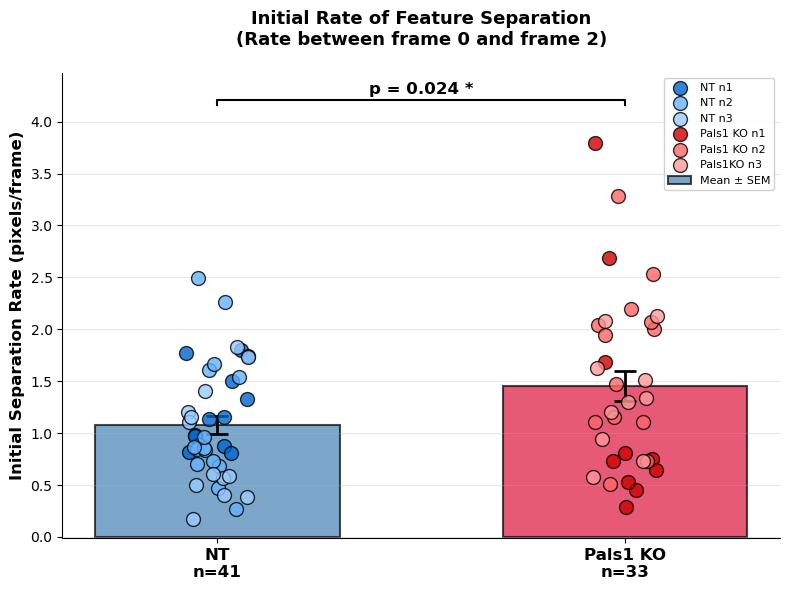


✅ INITIAL RATE ANALYSIS COMPLETE!


In [4]:
# ============================================================================
# CALCULATE INITIAL RATE OF FEATURE SEPARATION FOR ALL SAMPLES
# ============================================================================
# This cell calculates the initial rate (slope) of feature separation
# between frame 0 and frame 1 and creates a bar graph comparing groups
# ============================================================================

import numpy as np
from scipy.stats import linregress

print("="*70)
print(f"CALCULATING INITIAL RATE OF FEATURE SEPARATION")
print(f"Using rate between relative frame 0 and frame 2 (actual frame 0 and frame 1)")
print("="*70)

def calculate_initial_rate(sample_data_dict):
    """
    Calculate initial rate of feature separation using the y coordinates 
    at relative frame 0 and 1.
    Rate = (y1 - y0) / 2
    Frame 0 = time 0, Frame 1 = time 2 (relative frame 2), so denominator is 2
    
    Returns:
    - slope (rate in pixels/frame)
    """
    df = sample_data_dict['data']
    
    # Get data for frames 0 and 1
    df_sorted = df.sort_values('Relative Frame')
    
    # Get the y values (Distance Change) for frames 0 and 1
    # Note: Frame 0 = Relative Frame 0, Frame 1 = Relative Frame 2
    y0 = df_sorted[df_sorted['Relative Frame'] == 0]['Distance Change'].values
    y1 = df_sorted[df_sorted['Relative Frame'] == 2]['Distance Change'].values
    
    if len(y0) == 0 or len(y1) == 0:
        print(f"⚠️  Not enough data points for {sample_data_dict['name']}")
        return None
    
    # Use the first value if there are multiple (should be only one per frame)
    y0 = y0[0]
    y1 = y1[0]
    
    # Calculate rate between frame 0 and frame 1
    # Since frame 0 = time 0 and frame 1 = relative frame 2 = time 2, 
    # the time difference is 2, so we divide by 2
    slope = (y1 - y0) / 2
    
    return slope

# Calculate rates for all samples
print("\nCalculating rates for NT samples...")
nt_n1_rates = []
for sample in nt_n1_data:
    rate = calculate_initial_rate(sample)
    if rate is not None:
        nt_n1_rates.append(rate)
        print(f"  NT n1: {rate:.4f} pixels/frame")

nt_n2_rates = []
for sample in nt_n2_data:
    rate = calculate_initial_rate(sample)
    if rate is not None:
        nt_n2_rates.append(rate)
        print(f"  NT n2: {rate:.4f} pixels/frame")

nt_n3_rates = []
for sample in nt_n3_data:
    rate = calculate_initial_rate(sample)
    if rate is not None:
        nt_n3_rates.append(rate)
        print(f"  NT n3: {rate:.4f} pixels/frame")

print("\nCalculating rates for Pals1 KO samples...")
ko_n1_rates = []
for sample in ko_n1_data:
    rate = calculate_initial_rate(sample)
    if rate is not None:
        ko_n1_rates.append(rate)
        print(f"  KO n1: {rate:.4f} pixels/frame")

ko_n2_rates = []
for sample in ko_n2_data:
    rate = calculate_initial_rate(sample)
    if rate is not None:
        ko_n2_rates.append(rate)
        print(f"  KO n2: {rate:.4f} pixels/frame")

ko_n3_rates = []
for sample in ko_n3_data:
    rate = calculate_initial_rate(sample)
    if rate is not None:
        ko_n3_rates.append(rate)
        print(f"  KO n3: {rate:.4f} pixels/frame")

# Calculate mean and SEM for each group and repeat
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

def calc_mean_sem(data):
    if len(data) > 0:
        mean = np.mean(data)
        sem = np.std(data, ddof=1) / np.sqrt(len(data)) if len(data) > 1 else 0
        return mean, sem
    return 0, 0

nt_n1_mean, nt_n1_sem = calc_mean_sem(nt_n1_rates)
nt_n2_mean, nt_n2_sem = calc_mean_sem(nt_n2_rates)
nt_n3_mean, nt_n3_sem = calc_mean_sem(nt_n3_rates)
ko_n1_mean, ko_n1_sem = calc_mean_sem(ko_n1_rates)
ko_n2_mean, ko_n2_sem = calc_mean_sem(ko_n2_rates)
ko_n3_mean, ko_n3_sem = calc_mean_sem(ko_n3_rates)

print(f"\nNT Group:")
print(f"  Repeat 1 (n1): {nt_n1_mean:.4f} ± {nt_n1_sem:.4f} pixels/frame (n={len(nt_n1_rates)})")
print(f"  Repeat 2 (n2): {nt_n2_mean:.4f} ± {nt_n2_sem:.4f} pixels/frame (n={len(nt_n2_rates)})")
print(f"  Repeat 3 (n3): {nt_n3_mean:.4f} ± {nt_n3_sem:.4f} pixels/frame (n={len(nt_n3_rates)})")

print(f"\nPals1 KO Group:")
print(f"  Repeat 1 (n1): {ko_n1_mean:.4f} ± {ko_n1_sem:.4f} pixels/frame (n={len(ko_n1_rates)})")
print(f"  Repeat 2 (n2): {ko_n2_mean:.4f} ± {ko_n2_sem:.4f} pixels/frame (n={len(ko_n2_rates)})")
print(f"  Repeat 3 (n3): {ko_n3_mean:.4f} ± {ko_n3_sem:.4f} pixels/frame (n={len(ko_n3_rates)})")

# ============================================================================
# CREATE BAR GRAPH WITH INDIVIDUAL DATA POINTS
# ============================================================================

print("\n" + "="*70)
print("GENERATING BAR GRAPH...")
print("="*70)

# Create figure with single bar graph
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Define bar positions
x_pos = np.array([0, 1])  # NT and KO groups
bar_width = 0.6

# Prepare data for bar plot
nt_means = [nt_n1_mean, nt_n2_mean, nt_n3_mean]
nt_sems = [nt_n1_sem, nt_n2_sem, nt_n3_sem]
ko_means = [ko_n1_mean, ko_n2_mean, ko_n3_mean]
ko_sems = [ko_n1_sem, ko_n2_sem, ko_n3_sem]

# Calculate overall mean for each group (across all repeats)
all_nt_rates = nt_n1_rates + nt_n2_rates + nt_n3_rates
all_ko_rates = ko_n1_rates + ko_n2_rates + ko_n3_rates

nt_overall_mean, nt_overall_sem = calc_mean_sem(all_nt_rates)
ko_overall_mean, ko_overall_sem = calc_mean_sem(all_ko_rates)

# Plot bars for overall means
bars = ax.bar(x_pos, [nt_overall_mean, ko_overall_mean], 
              width=bar_width, 
              color=['#4682B4', '#DC143C'],
              alpha=0.7,
              edgecolor='black',
              linewidth=1.5,
              label='Mean ± SEM')

# Add error bars
ax.errorbar(x_pos, [nt_overall_mean, ko_overall_mean],
            yerr=[nt_overall_sem, ko_overall_sem],
            fmt='none',
            ecolor='black',
            capsize=8,
            capthick=2,
            linewidth=2)

# Define colors for individual data points (repeats)
repeat_colors = {
    'n1': '#000080',  # Dark blue/red for repeat 1
    'n2': '#4169E1',  # Medium blue/red for repeat 2
    'n3': '#87CEEB'   # Light blue/red for repeat 3
}

# Add individual data points for NT group
jitter_amount = 0.08
np.random.seed(42)  # For reproducible jitter

# NT repeat 1
x_jitter = x_pos[0] + np.random.uniform(-jitter_amount, jitter_amount, len(nt_n1_rates))
ax.scatter(x_jitter, nt_n1_rates, 
           color=nt_n1_color, s=100, alpha=0.8, 
           edgecolors='black', linewidth=1, 
           label='NT n1', zorder=3)

# NT repeat 2
x_jitter = x_pos[0] + np.random.uniform(-jitter_amount, jitter_amount, len(nt_n2_rates))
ax.scatter(x_jitter, nt_n2_rates, 
           color=nt_n2_color, s=100, alpha=0.8, 
           edgecolors='black', linewidth=1, 
           label='NT n2', zorder=3)

# NT repeat 3
x_jitter = x_pos[0] + np.random.uniform(-jitter_amount, jitter_amount, len(nt_n3_rates))
ax.scatter(x_jitter, nt_n3_rates, 
           color=nt_n3_color, s=100, alpha=0.8, 
           edgecolors='black', linewidth=1, 
           label='NT n3', zorder=3)

# Add individual data points for Pals1 KO group
# KO repeat 1
x_jitter = x_pos[1] + np.random.uniform(-jitter_amount, jitter_amount, len(ko_n1_rates))
ax.scatter(x_jitter, ko_n1_rates, 
           color=ko_n1_color, s=100, alpha=0.8, 
           edgecolors='black', linewidth=1, 
           label='Pals1 KO n1', zorder=3)

# KO repeat 2
x_jitter = x_pos[1] + np.random.uniform(-jitter_amount, jitter_amount, len(ko_n2_rates))
ax.scatter(x_jitter, ko_n2_rates, 
           color=ko_n2_color, s=100, alpha=0.8, 
           edgecolors='black', linewidth=1, 
           label='Pals1 KO n2', zorder=3)

# KO repeat 3
x_jitter = x_pos[1] + np.random.uniform(-jitter_amount, jitter_amount, len(ko_n3_rates))
ax.scatter(x_jitter, ko_n3_rates, 
           color=ko_n3_color, s=100, alpha=0.8, 
           edgecolors='black', linewidth=1, 
           label='Pals1KO n3', zorder=3)

# ============================================================================
# STATISTICAL ANALYSIS - T-TEST
# ============================================================================
from scipy.stats import ttest_ind

# Perform independent t-test between NT and KO groups
t_statistic, p_value = ttest_ind(all_nt_rates, all_ko_rates)

print(f"\n{'='*70}")
print(f"STATISTICAL ANALYSIS")
print(f"{'='*70}")
print(f"Independent t-test:")
print(f"  t-statistic: {t_statistic:.4f}")
print(f"  p-value: {p_value:.4e}")
if p_value < 0.001:
    significance = "***"
    print(f"  Significance: p < 0.001 (***)")
elif p_value < 0.01:
    significance = "**"
    print(f"  Significance: p < 0.01 (**)")
elif p_value < 0.05:
    significance = "*"
    print(f"  Significance: p < 0.05 (*)")
else:
    significance = "ns"
    print(f"  Significance: Not significant (ns)")
print(f"{'='*70}\n")

# Add significance bracket and p-value to the plot
# Find the maximum value among all data points to position bracket correctly
y_max_data = max(max(all_nt_rates), max(all_ko_rates))
y_min_data = min(min(all_nt_rates), min(all_ko_rates))
data_range = y_max_data - y_min_data

# Position bracket above the highest data point
bracket_height = y_max_data + data_range * 0.1
y_bracket = bracket_height

# Draw significance bracket
bracket_width = data_range * 0.015  # Adjust bracket arm height
ax.plot([x_pos[0], x_pos[0], x_pos[1], x_pos[1]], 
        [y_bracket, y_bracket + bracket_width, y_bracket + bracket_width, y_bracket],
        linewidth=1.5, color='black')

# Add p-value text
if p_value < 0.001:
    p_text = f"p < 0.001 {significance}"
elif p_value < 0.01:
    p_text = f"p = {p_value:.3f} {significance}"
else:
    p_text = f"p = {p_value:.3f} {significance}"

ax.text((x_pos[0] + x_pos[1]) / 2, y_bracket + bracket_width * 1.5, p_text,
        ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize plot
ax.set_ylabel('Initial Separation Rate (pixels/frame)', fontsize=12, fontweight='bold')
ax.set_title('Initial Rate of Feature Separation\n(Rate between frame 0 and frame 2)', 
             fontsize=13, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(['NT\nn={}'.format(len(all_nt_rates)), 
                     'Pals1 KO\nn={}'.format(len(all_ko_rates))], 
                    fontsize=12, fontweight='bold')
ax.legend(fontsize=8, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust y-axis limits to ensure all data points and p-value text are visible
# Set y_min slightly below the minimum data point
# Set y_max to accommodate p-value text above the bracket
y_axis_min = y_min_data - data_range * 0.05
y_axis_max = y_bracket + bracket_width * 2.5 + data_range * 0.05
ax.set_ylim(y_axis_min, y_axis_max)

plt.tight_layout()
plt.savefig(notebook_dir / "Initial_Separation_Rate_Comparison.png", dpi=300, bbox_inches='tight')
print("✓ Figure saved: Initial_Separation_Rate_Comparison.png")
plt.show()

print("\n" + "="*70)
print("✅ INITIAL RATE ANALYSIS COMPLETE!")
print("="*70)